In [1]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install required package and libraries

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
import os
import numpy as np
import cv2
from ultralytics import YOLOv10
import xml.etree.ElementTree as ET
import shutil
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Image
import yaml
HOME = os.getcwd()
print(HOME)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content


Convert COCO annotation format to YOLO

In [ ]:
def convert_voc_to_yolo(xml_file, txt_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            class_id = class_name_to_id[class_name]  # Convert class name to class ID

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Convert from Pascal VOC format to YOLO format
            x_center = (xmin + xmax) / 2.0 / image_width
            y_center = (ymin + ymax) / 2.0 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

#Funtion to create YOLO annotation file
def create_yolo_annotations(xml_folder, output_folder, image_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_folder, xml_file)
            image_name = os.path.splitext(xml_file)[0] + '.jpg'
            image_path = os.path.join(image_folder, image_name)

            # Implement this function to get image size
            image_width, image_height = get_image_size(image_path)

            txt_file = os.path.join(output_folder, os.path.splitext(xml_file)[0] + '.txt')
            convert_voc_to_yolo(xml_path, txt_file, image_width, image_height)

def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]

# Define folder path for images, COCO annotation and YOLO annotation
xml_folder = '/content/drive/MyDrive/NEU-DET/annotation'
output_folder = '/content/drive/MyDrive/NEU-DET/YOLO_annotation'
image_folder = '/content/drive/MyDrive/NEU-DET/images'

# Mapping actual class names to corresponding IDs
class_name_to_id = {
    'crazing': 0,
    'inclusion': 1,
    'patches': 2,
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5

}
#Execute function
create_yolo_annotations(xml_folder, output_folder, image_folder)

Split dataset into Train, test, and validation set.

In [ ]:
#Define data splitting function
def split_data_with_annotations(source_dir, annotation_dir, train_dir, val_dir, test_dir,
                                train_anno_dir, val_anno_dir, test_anno_dir,
                                train_split=0.7, val_split=0.15, test_split=0.15):
    """
    Splits the image data and their corresponding annotations into training, validation, and testing sets.

    Parameters:
    source_dir (str): The directory containing the original images.
    annotation_dir (str): The directory containing the annotations for the images.
    train_dir (str): The directory where the training images will be saved.
    val_dir (str): The directory where the validation images will be saved.
    test_dir (str): The directory where the test images will be saved.
    train_anno_dir (str): The directory where the training annotations will be saved.
    val_anno_dir (str): The directory where the validation annotations will be saved.
    test_anno_dir (str): The directory where the test annotations will be saved.
    train_split (float): The proportion of images to include in the training set.
    val_split (float): The proportion of images to include in the validation set.
    test_split (float): The proportion of images to include in the test set.
    """

    # Ensure the destination directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(train_anno_dir, exist_ok=True)
    os.makedirs(val_anno_dir, exist_ok=True)
    os.makedirs(test_anno_dir, exist_ok=True)

    # Get all image file names from the source directory
    image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and f.endswith('.jpg')]

    # Shuffle the image files
    random.shuffle(image_files)

    # Calculate the split indices
    train_idx = int(len(image_files) * train_split)
    val_idx = train_idx + int(len(image_files) * val_split)

    # Split the images
    train_files = image_files[:train_idx]
    val_files = image_files[train_idx:val_idx]
    test_files = image_files[val_idx:]

    # Copy the files and their corresponding annotations to their respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name))
        shutil.copy(os.path.join(annotation_dir, file_name.replace('.jpg', '.txt')),
                    os.path.join(train_anno_dir, file_name.replace('.jpg', '.txt')))

    for file_name in val_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(val_dir, file_name))
        shutil.copy(os.path.join(annotation_dir, file_name.replace('.jpg', '.txt')),
                    os.path.join(val_anno_dir, file_name.replace('.jpg', '.txt')))

    for file_name in test_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(test_dir, file_name))
        shutil.copy(os.path.join(annotation_dir, file_name.replace('.jpg', '.txt')),
                    os.path.join(test_anno_dir, file_name.replace('.jpg', '.txt')))

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")
    print(f"Test set: {len(test_files)} images")

#Define folder path
source_directory = '/content/drive/MyDrive/NEU-DET/images'
annotation_directory = '/content/drive/MyDrive/NEU-DET/YOLO_annotation'
train_directory = '/content/drive/MyDrive/NEU-DET/train/images'
train_annotation_directory = '/content/drive/MyDrive/NEU-DET/train/labels'
validation_directory = '/content/drive/MyDrive/NEU-DET/val/images'
validation_annotation_directory = '/content/drive/MyDrive/NEU-DET/val/labels'
test_directory = '/content/drive/MyDrive/NEU-DET/test/images'
test_annotation_directory = '/content/drive/MyDrive/NEU-DET/test/labels'

#Execute data splitting function
split_data_with_annotations(source_directory, annotation_directory,
                            train_directory, validation_directory, test_directory,
                            train_annotation_directory, validation_annotation_directory, test_annotation_directory)





Training set: 1260 images
Validation set: 270 images
Test set: 270 images


Perform data augmentation on training set

In [ ]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_visibility=0.2))

# Function to augment image and bounding boxes in YOLO format
def augment_image_and_bboxes_yolo(image_path, bboxes, labels, images_output_dir, annotations_output_dir, aug_pipeline, num_augmentations=2):
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path).split('.')[0]

    for i in range(num_augmentations):
        augmented = aug_pipeline(image=image, bboxes=bboxes, labels=labels)
        augmented_image = augmented["image"]
        augmented_bboxes = augmented["bboxes"]
        augmented_labels = augmented["labels"]

        # Convert the image to the correct format and save it
        augmented_image= augmented_image.permute(1, 2, 0).cpu().numpy()
        augmented_image_path = os.path.join(images_output_dir, f"{image_name}_aug_{i}.jpg")
        cv2.imwrite(augmented_image_path, augmented_image)

        # Save augmented bounding boxes in YOLO format
        augmented_bboxes_path = os.path.join(annotations_output_dir, f"{image_name}_aug_{i}.txt")
        with open(augmented_bboxes_path, 'w') as f:
            for bbox, label in zip(augmented_bboxes, augmented_labels):
                x_center, y_center, bbox_width, bbox_height = bbox
                f.write(f"{label} {x_center} {y_center} {bbox_width} {bbox_height}\n")

        print(f"Saved augmented image and bboxes: {augmented_image_path}, {augmented_bboxes_path}")

# Path where images and annotations are stored
images_dir = '/content/drive/MyDrive/NEU-DET/train/images'
annotations_dir = '/content/drive/MyDrive/NEU-DET/train/labels'
images_output_dir = '/content/drive/MyDrive/NEU-DET/train/images'
annotations_output_dir = '/content/drive/MyDrive/NEU-DET/train/labels'

# Create output directories if they don't exist
os.makedirs(images_output_dir, exist_ok=True)
os.makedirs(annotations_output_dir, exist_ok=True)

# List all images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Augment each image
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    annotation_path = os.path.join(annotations_dir, image_file.replace('.jpg', '.txt'))

    # Read annotations in YOLO format
    bboxes = []
    labels = []
    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            label, x_center, y_center, width, height = map(float, line.strip().split())
            labels.append(int(label))
            bboxes.append([x_center, y_center, width, height])  # Keep in YOLO format
  #Execute data augmentation function
    augment_image_and_bboxes_yolo(image_path, bboxes, labels,images_output_dir, annotations_output_dir, augmentation_pipeline)

Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/pitted_surface_72_aug_0.jpg, /content/drive/MyDrive/NEU-DET/train/labels/pitted_surface_72_aug_0.txt
Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/pitted_surface_72_aug_1.jpg, /content/drive/MyDrive/NEU-DET/train/labels/pitted_surface_72_aug_1.txt
Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/patches_63_aug_0.jpg, /content/drive/MyDrive/NEU-DET/train/labels/patches_63_aug_0.txt
Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/patches_63_aug_1.jpg, /content/drive/MyDrive/NEU-DET/train/labels/patches_63_aug_1.txt
Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/scratches_33_aug_0.jpg, /content/drive/MyDrive/NEU-DET/train/labels/scratches_33_aug_0.txt
Saved augmented image and bboxes: /content/drive/MyDrive/NEU-DET/train/images/scratches_33_aug_1.jpg, /content/drive/MyDrive/NEU-DET/train/labe

Model training

In [3]:
#Download the YOLOv10 pre-trained weight
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 23 09:38 yolov10b.pt
-rw-r--r-- 1 root root 100M May 23 09:38 yolov10l.pt
-rw-r--r-- 1 root root  64M May 23 09:38 yolov10m.pt
-rw-r--r-- 1 root root  11M May 23 09:38 yolov10n.pt
-rw-r--r-- 1 root root  32M May 23 09:38 yolov10s.pt
-rw-r--r-- 1 root root 123M May 23 09:38 yolov10x.pt


Write data.yaml file for training

In [4]:
#Define the data.yaml file for training
data = {
    'names': [
        'crazing',
        'inclusion',
        'patches',
        'pitted_surface',
        'rolled-in_scale',
        'scratches'
    ],
    'nc': 6, #Number of defect class
    'path': '/content/drive/MyDrive/NEU-DET',#Dataset path
    'test': 'test/images',#Testing data path
    'train': 'train/images',#Training data path
    'val': 'val/images'#Validation data path
}

# Path to the output data.yaml file
yaml_file_path = '/content/drive/MyDrive/NEU-DET/data.yaml'

# Write the content to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.safe_dump(data, file)

print(f"data.yaml file has been successfully written to {yaml_file_path}")


data.yaml file has been successfully written to /content/drive/MyDrive/NEU-DET/data.yaml


In [5]:
#Train the YOLOv10-X model for defect detection
%cd {HOME}
!yolo task=detect mode=train epochs=300 plots=True verbose=True batch=8 optimizer='SGD' lr0=0.001 imgsz=640 patience=100 \
model={HOME}/weights/yolov10x.pt \
data={HOME}/drive/MyDrive/NEU-DET/data.yaml

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New h

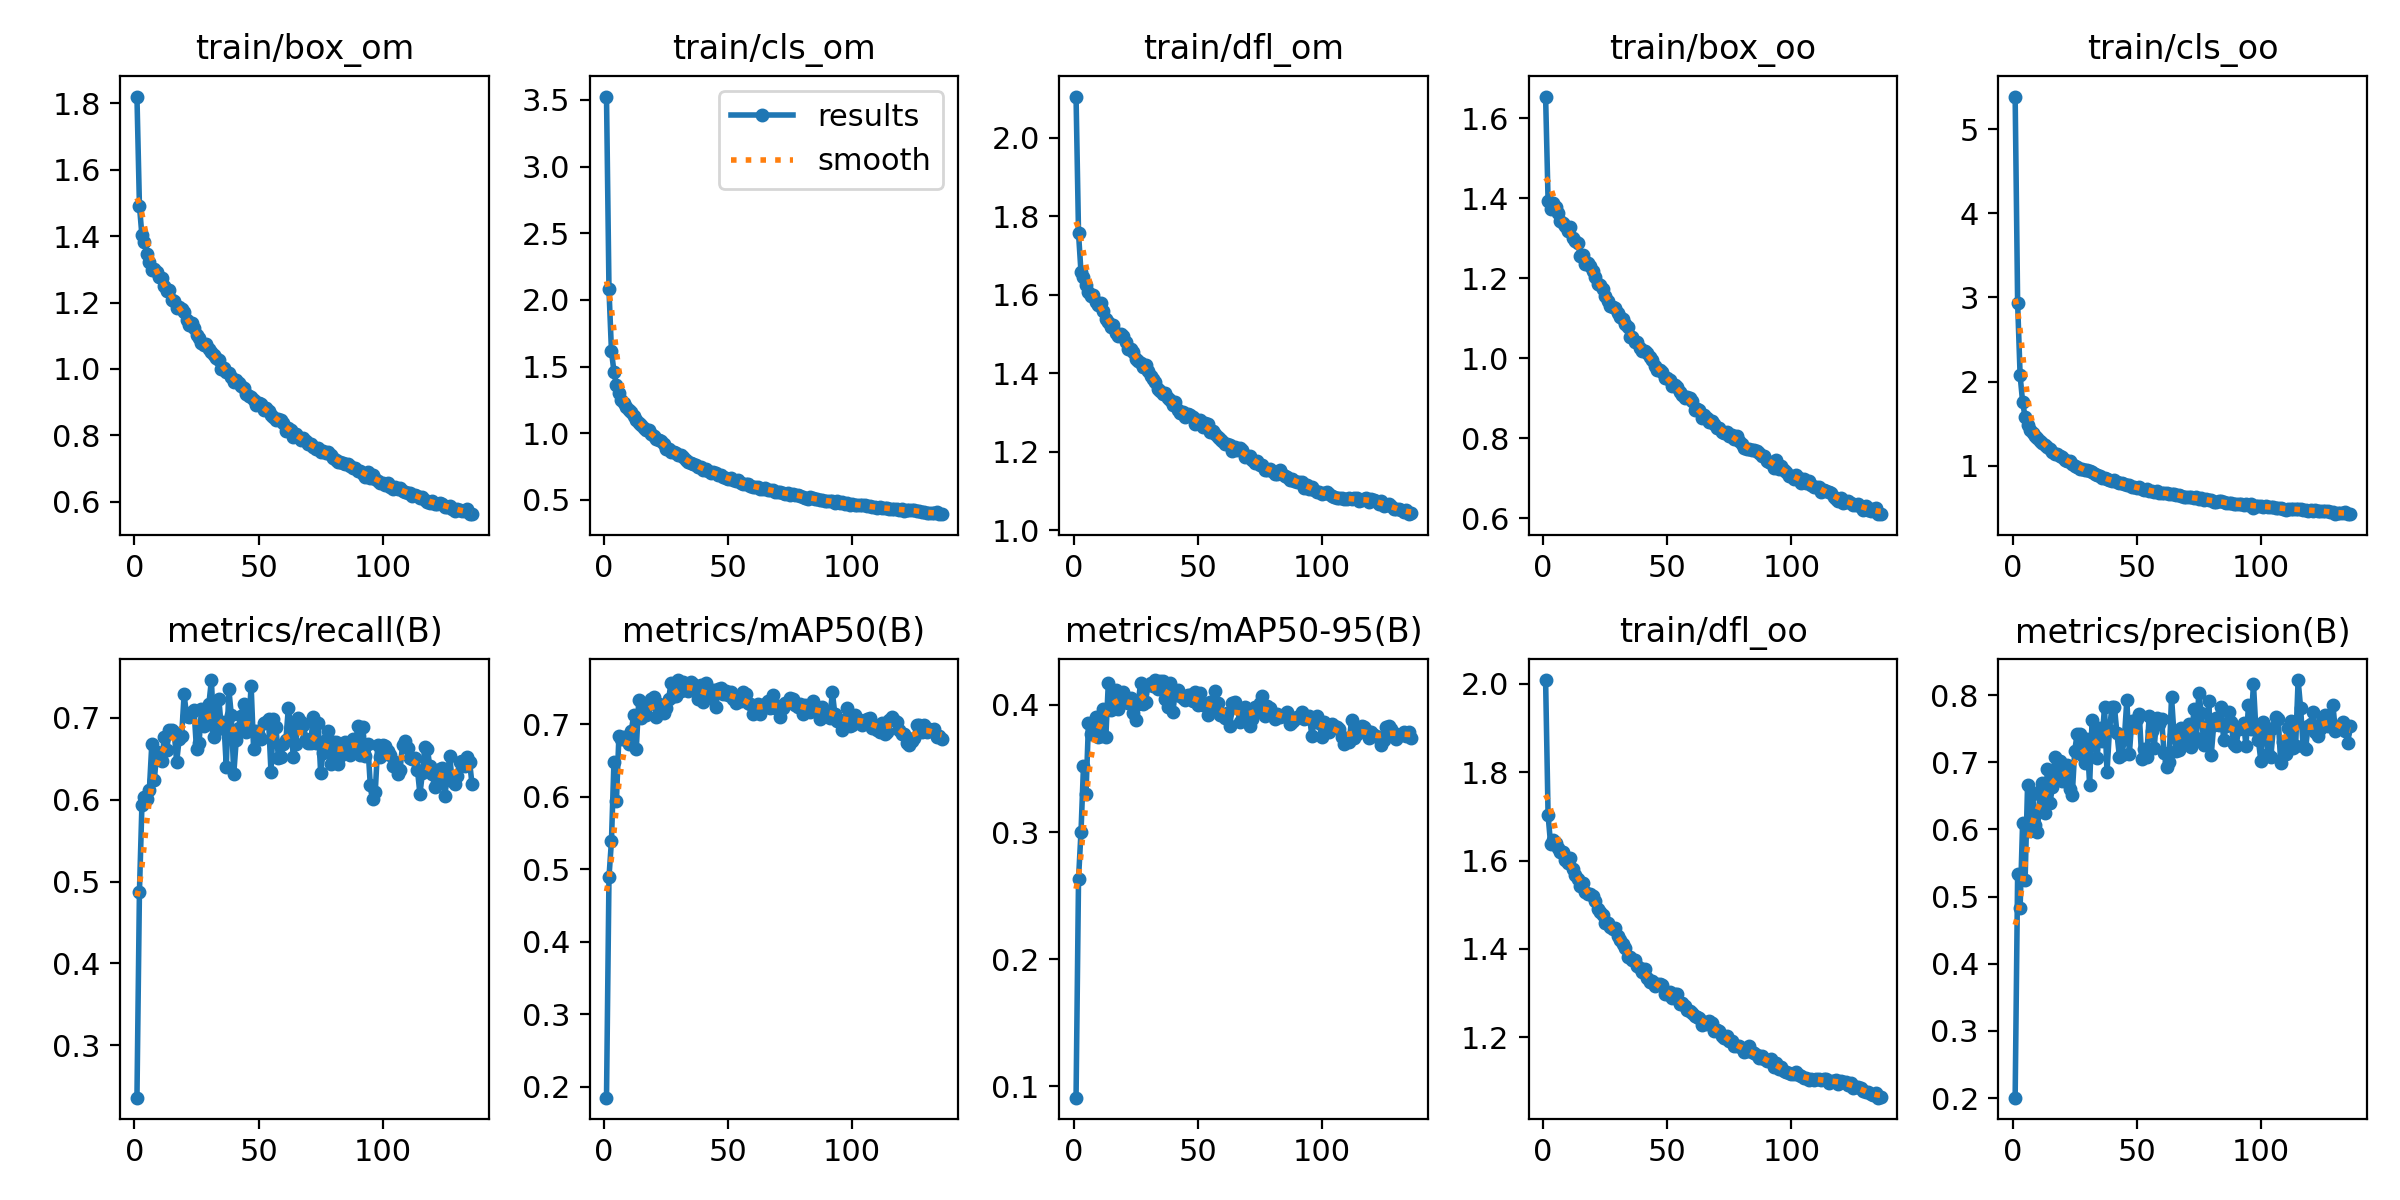

In [6]:
#Visualise the training process
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

Model Testing

In [7]:
#Perform prediction on testing set
model=YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')
model.predict(source='/content/drive/MyDrive/NEU-DET/test/images', save=True)


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



image 1/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_101.jpg: 640x640 2 crazings, 18.5ms
image 2/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_122.jpg: 640x640 1 crazing, 18.6ms
image 3/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_126.jpg: 640x640 2 crazings, 24.2ms
image 4/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_135.jpg: 640x640 2 crazings, 18.5ms
image 5/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_153.jpg: 640x640 2 crazings, 18.4ms
image 6/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_154.jpg: 640x640 2 crazings, 17.5ms
image 7/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_155.jpg: 640x640 4 crazings, 17.2ms
image 8/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_164.jpg: 640x640 2 crazings, 17.5ms
image 9/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_176.jpg: 640x640 2 crazings, 17.5ms
image 10/270 /content/drive/MyDrive/NEU-DET/test/images/crazing_188.jpg: 640x640 3 crazings, 17.3ms
image 11/

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}
 obb: None
 orig_img: array([[[174, 174, 174],
         [165, 165, 165],
         [145, 145, 145],
         ...,
         [173, 173, 173],
         [206, 206, 206],
         [194, 194, 194]],
 
        [[169, 169, 169],
         [151, 151, 151],
         [161, 161, 161],
         ...,
         [169, 169, 169],
         [169, 169, 169],
         [171, 171, 171]],
 
        [[186, 186, 186],
         [158, 158, 158],
         [160, 160, 160],
         ...,
         [174, 174, 174],
         [142, 142, 142],
         [165, 165, 165]],
 
        ...,
 
        [[164, 164, 164],
         [159, 159, 159],
         [153, 153, 153],
         ...,
         [154, 154, 154],
         [145, 145, 145],
         [138, 138, 138]],
 
        [[182, 182, 

In [8]:
#Evaluate trained yolov10 on testing set
test_results = model.val(split='test',plots=True)

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


val: Scanning /content/drive/MyDrive/NEU-DET/test/labels.cache... 270 images, 0 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:10<00:00,  1.67it/s]


                   all        270        621      0.756       0.72      0.777      0.469
               crazing        270        101      0.583      0.374      0.457      0.189
             inclusion        270        153      0.801      0.817      0.854      0.502
               patches        270        136      0.914      0.864      0.928      0.615
        pitted_surface        270         44      0.851      0.841      0.875      0.633
       rolled-in_scale        270        111      0.589      0.593      0.653      0.316
             scratches        270         76      0.797      0.829      0.897      0.562
Speed: 0.9ms preprocess, 28.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


Visualise testing result

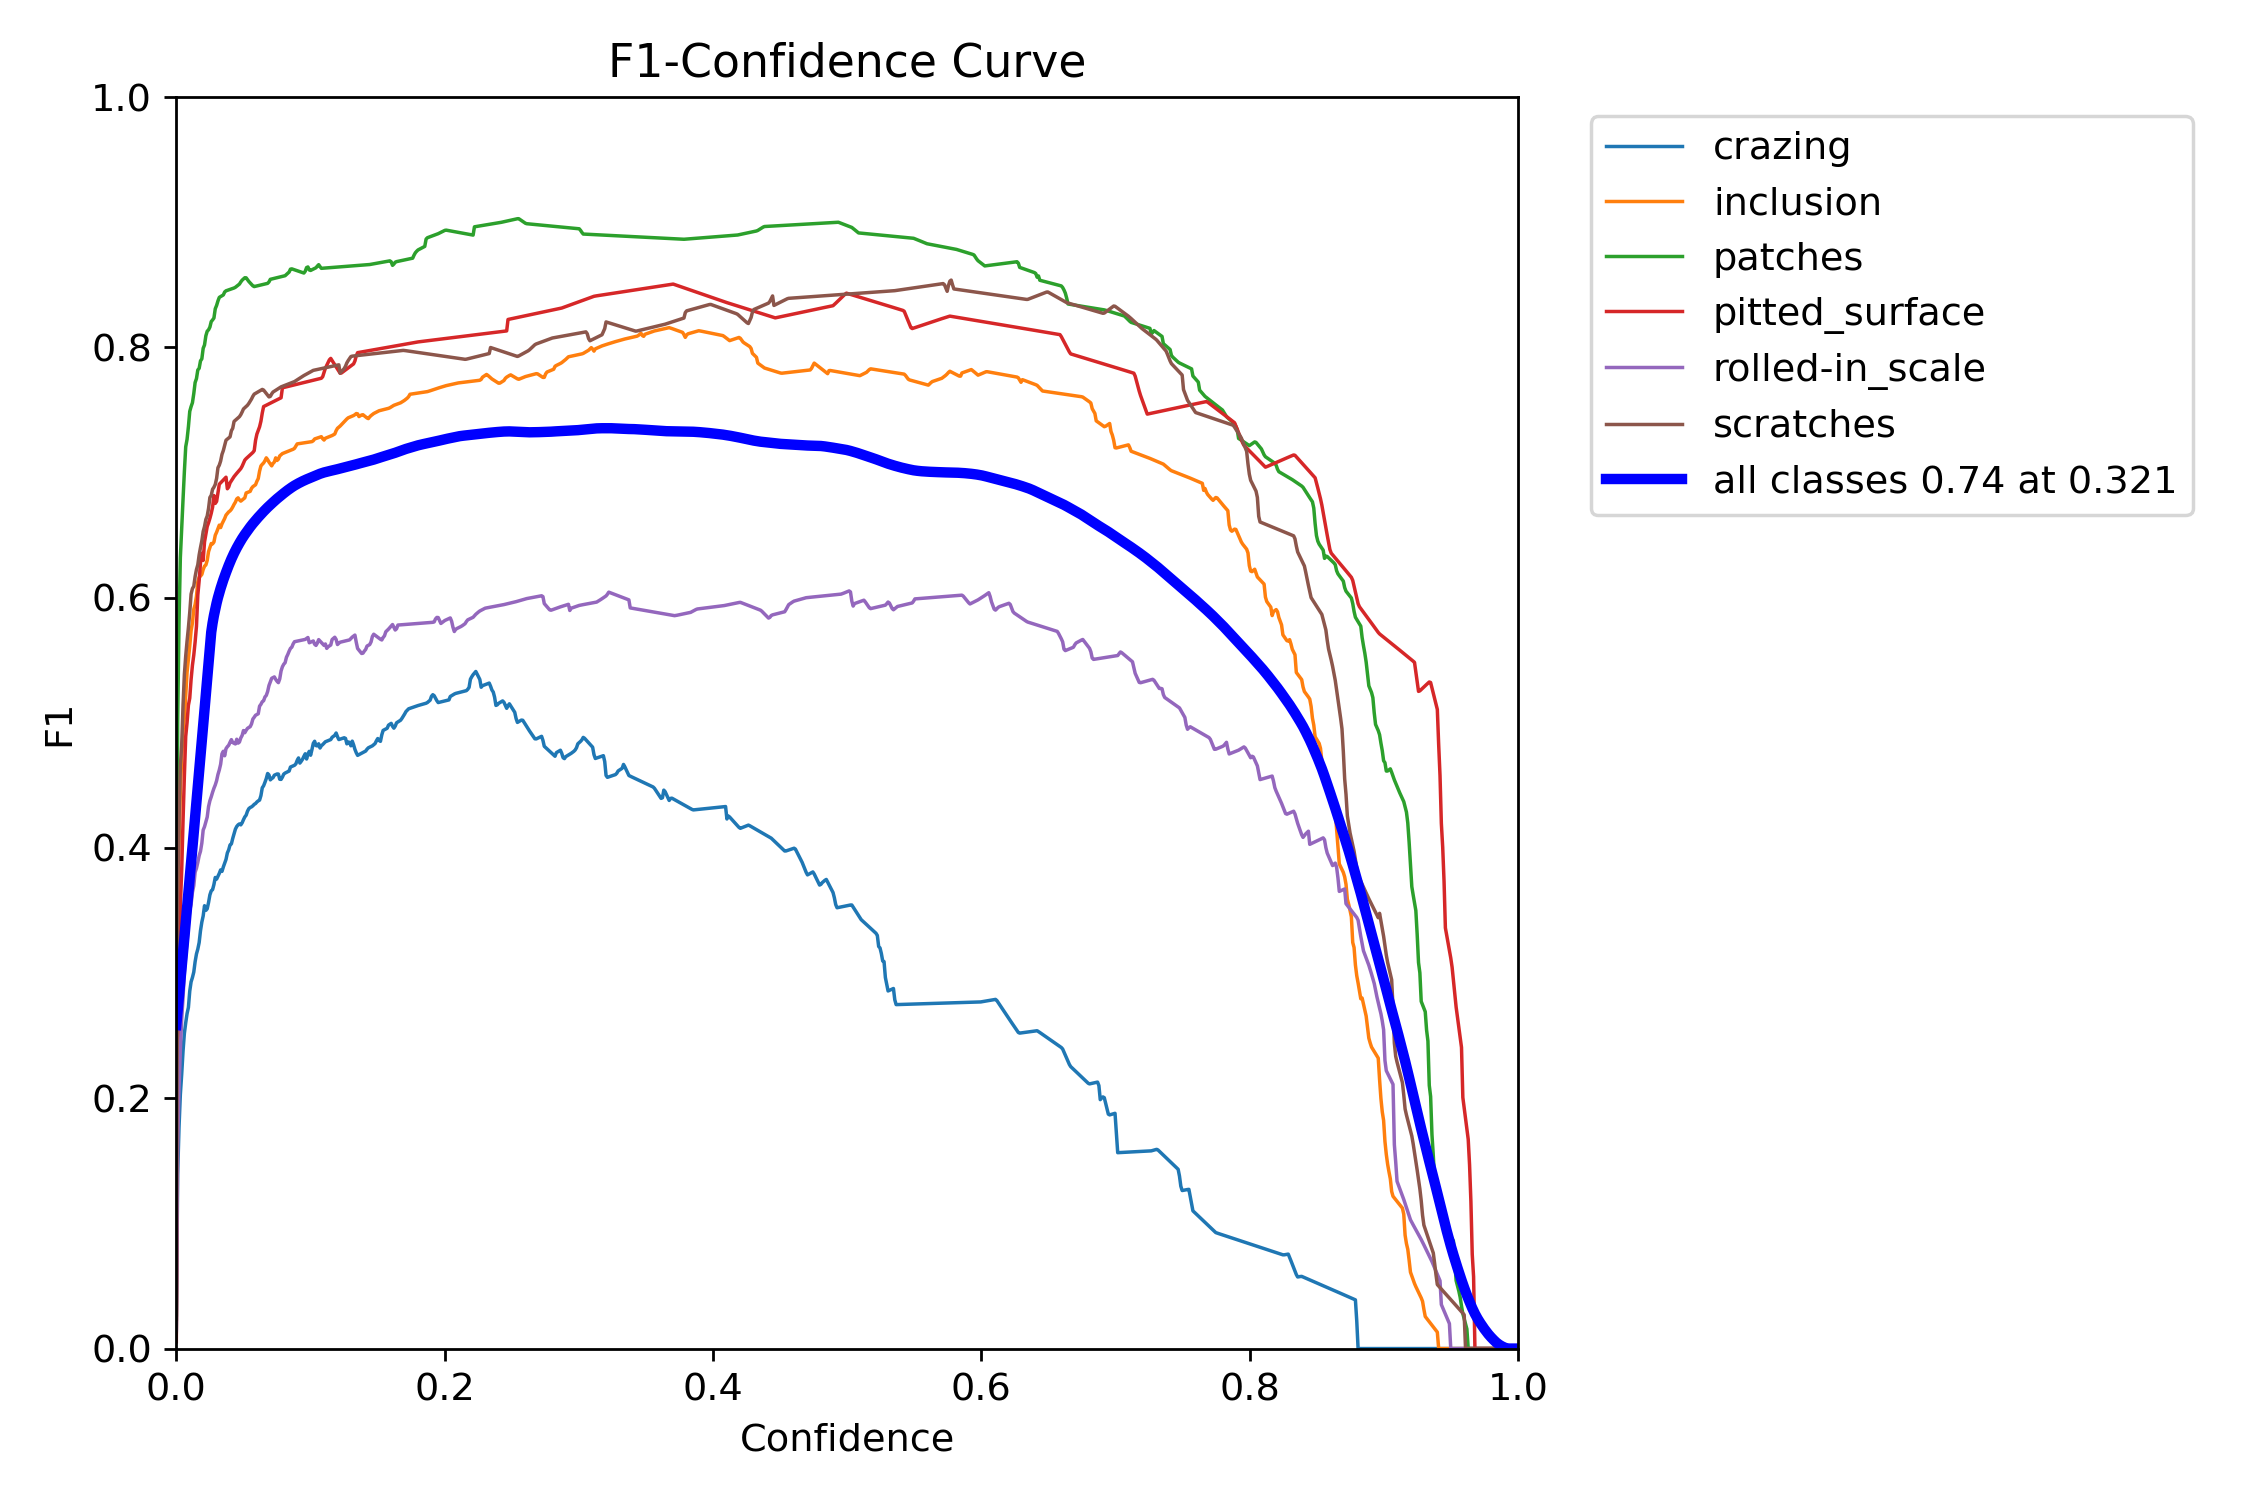

In [9]:
#F1 curve
Image(filename=f'{HOME}/runs/detect/val/F1_curve.png', width=600)

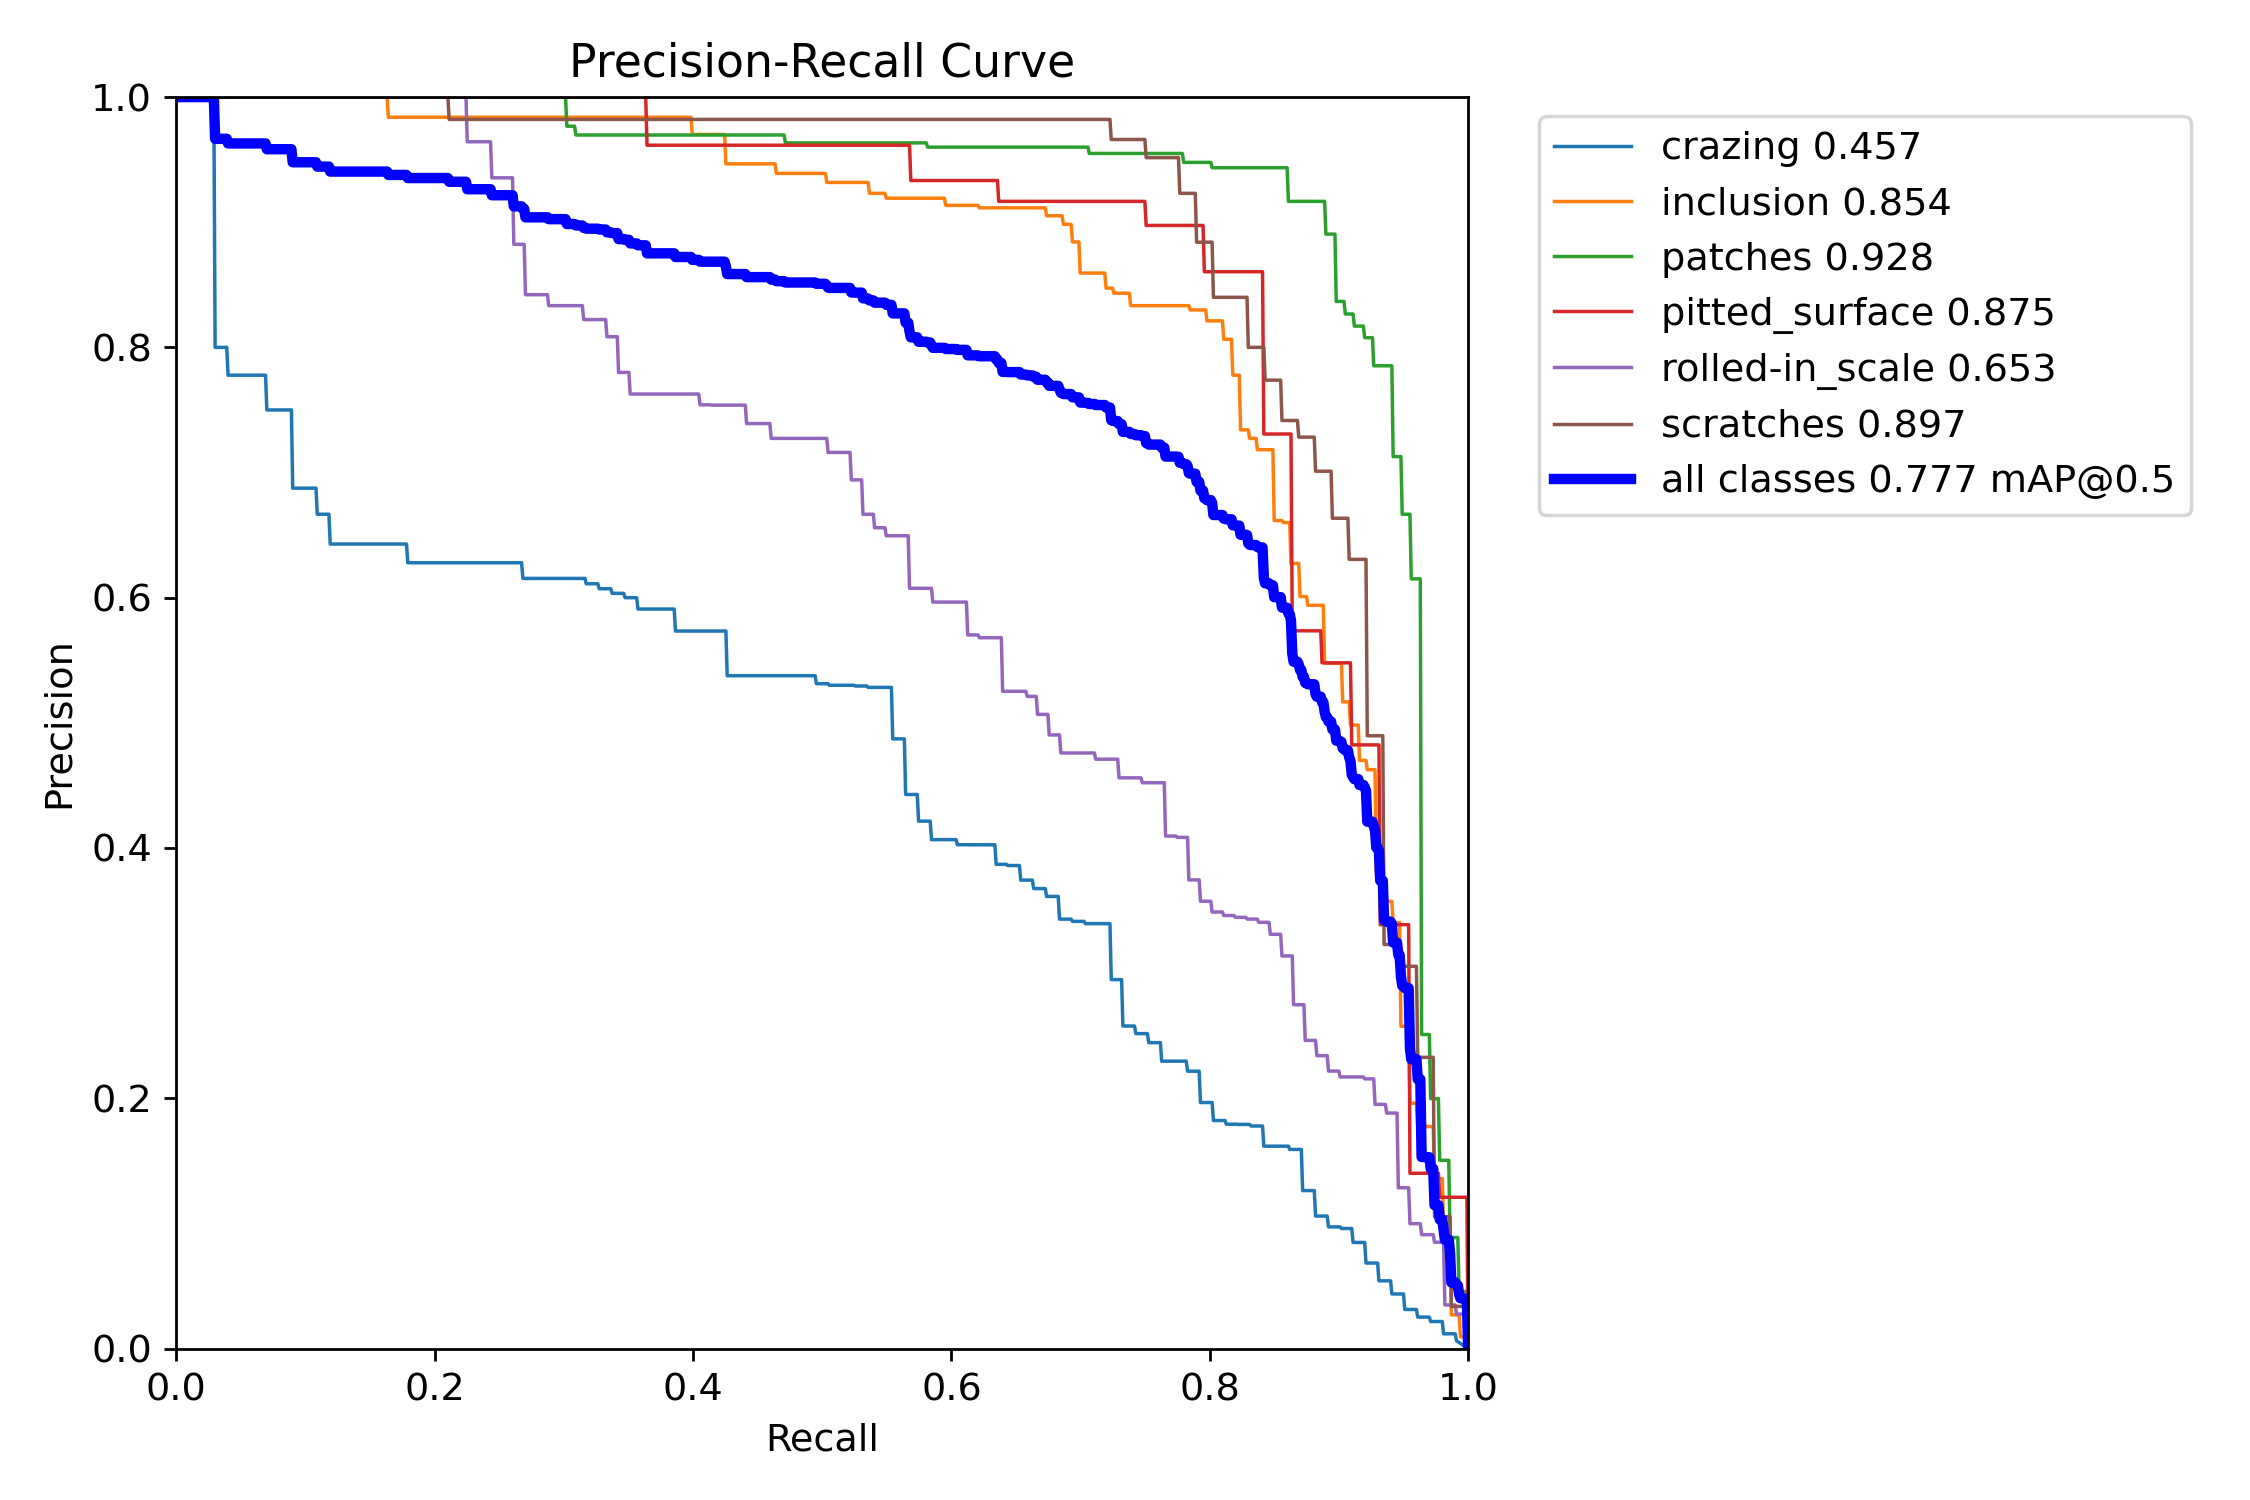

In [10]:
#Precison-recall curve
Image(filename=f'{HOME}/runs/detect/val/PR_curve.png', width=600)

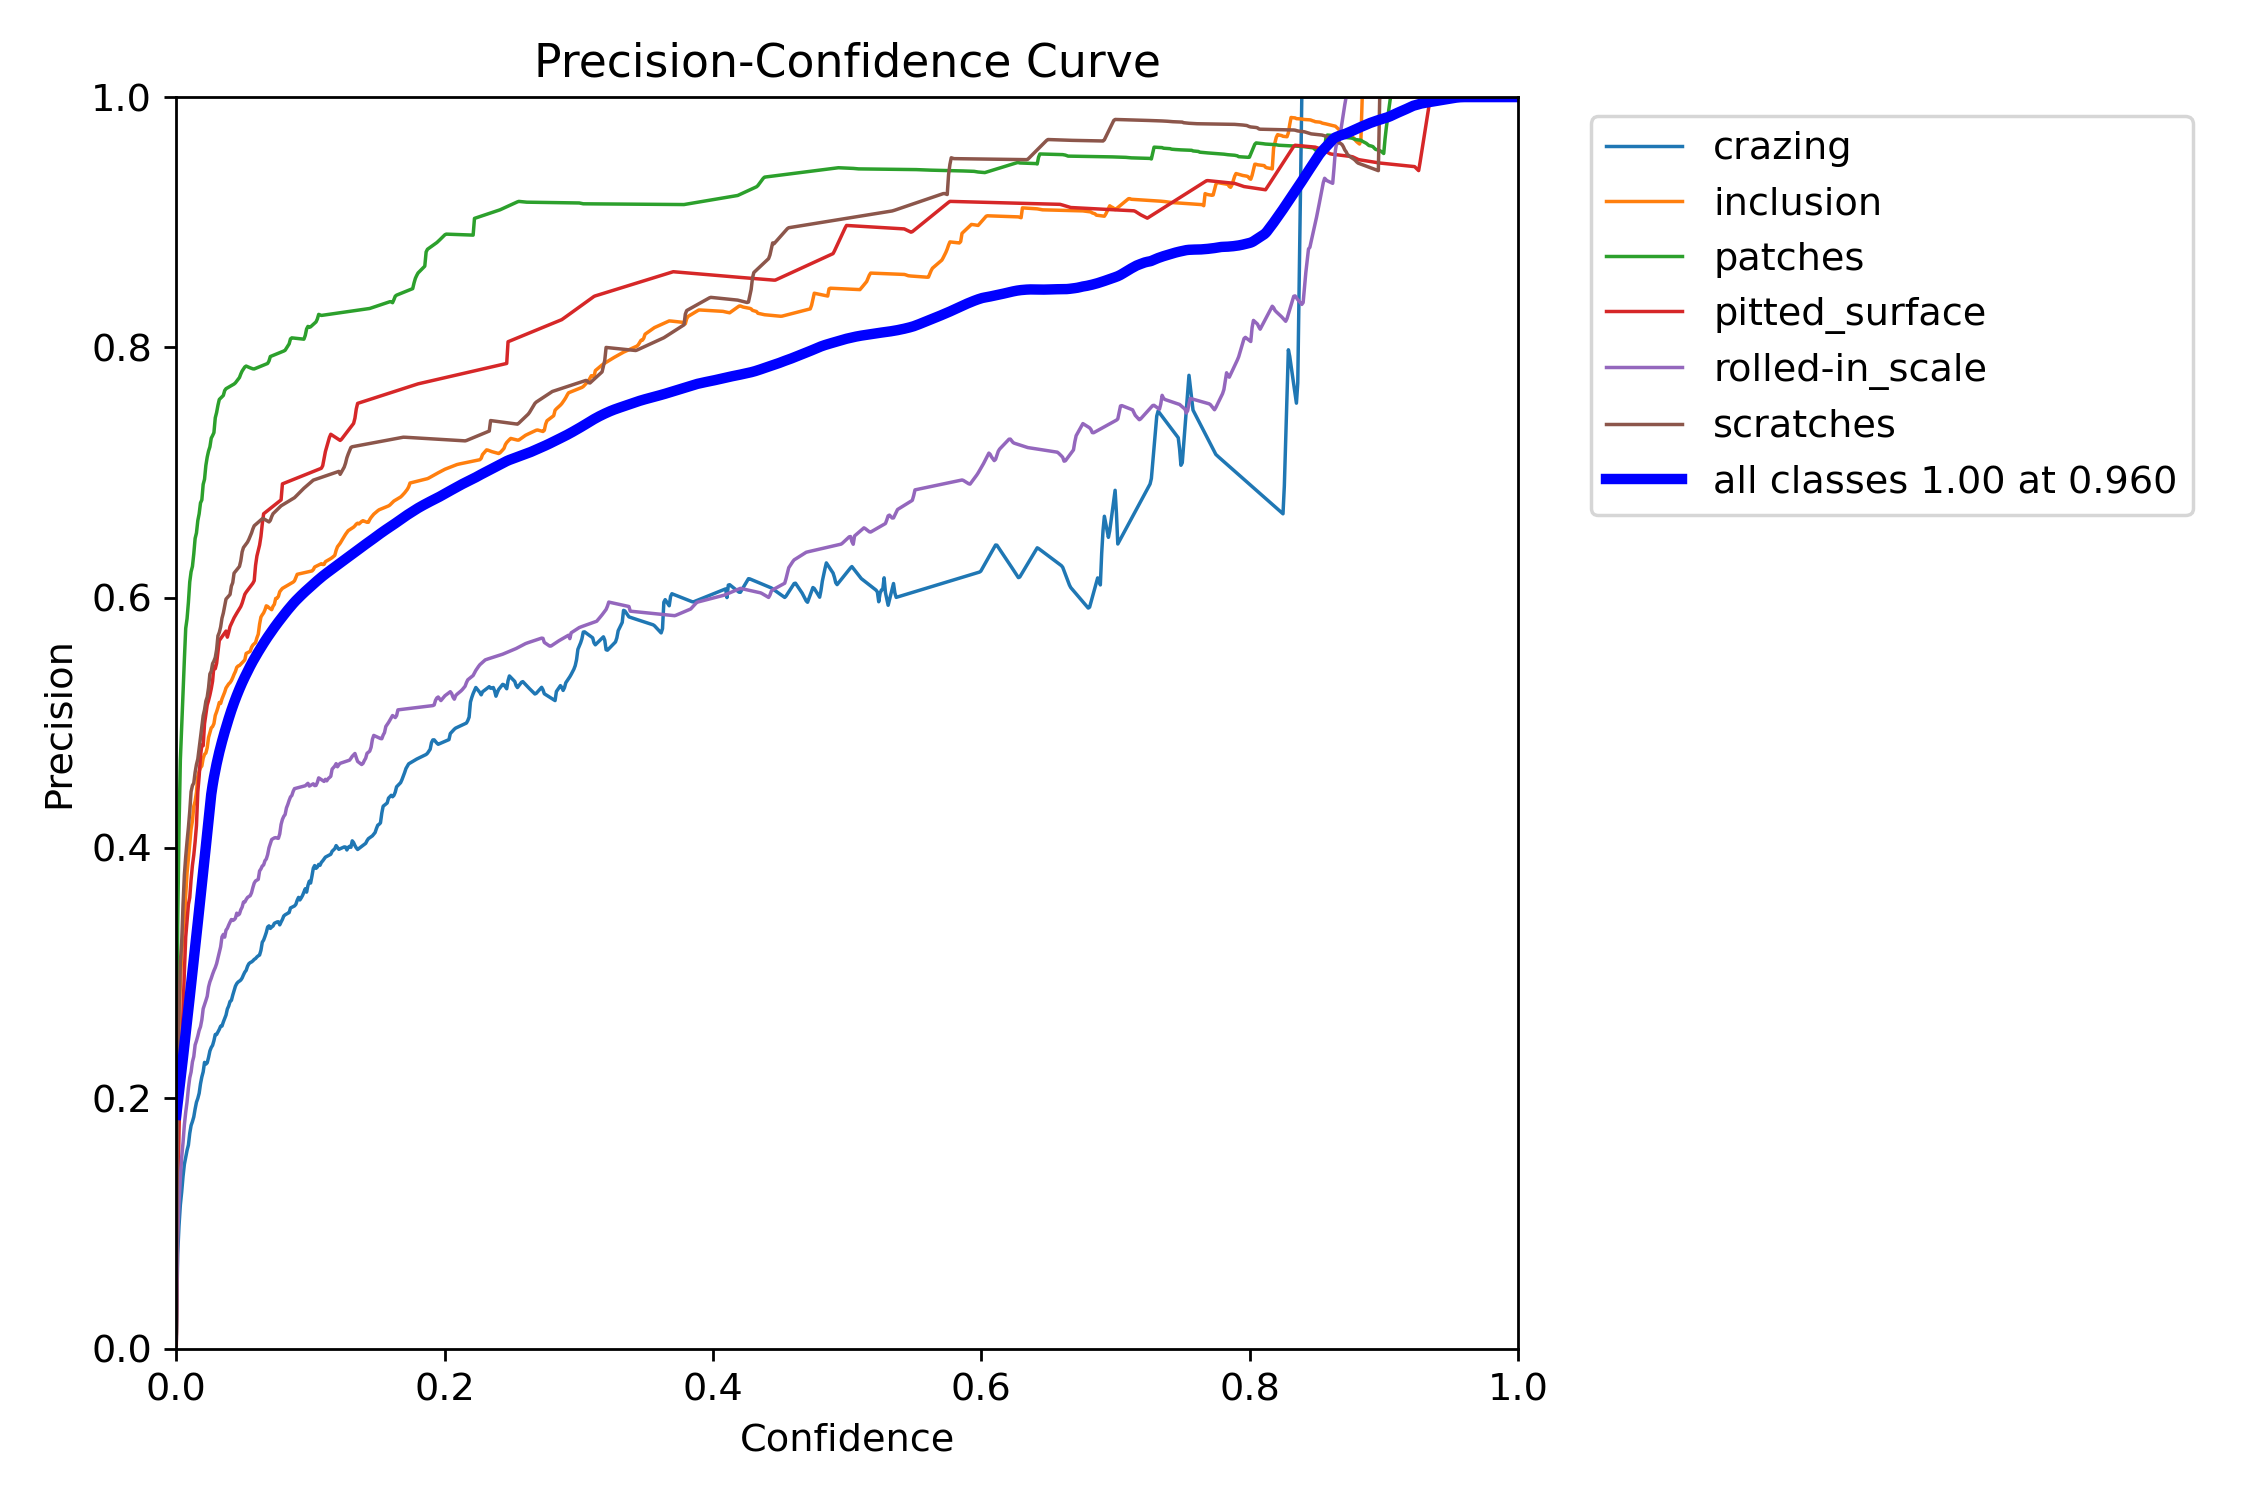

In [11]:
#precision-confidence curve
Image(filename=f'{HOME}/runs/detect/val/P_curve.png', width=600)

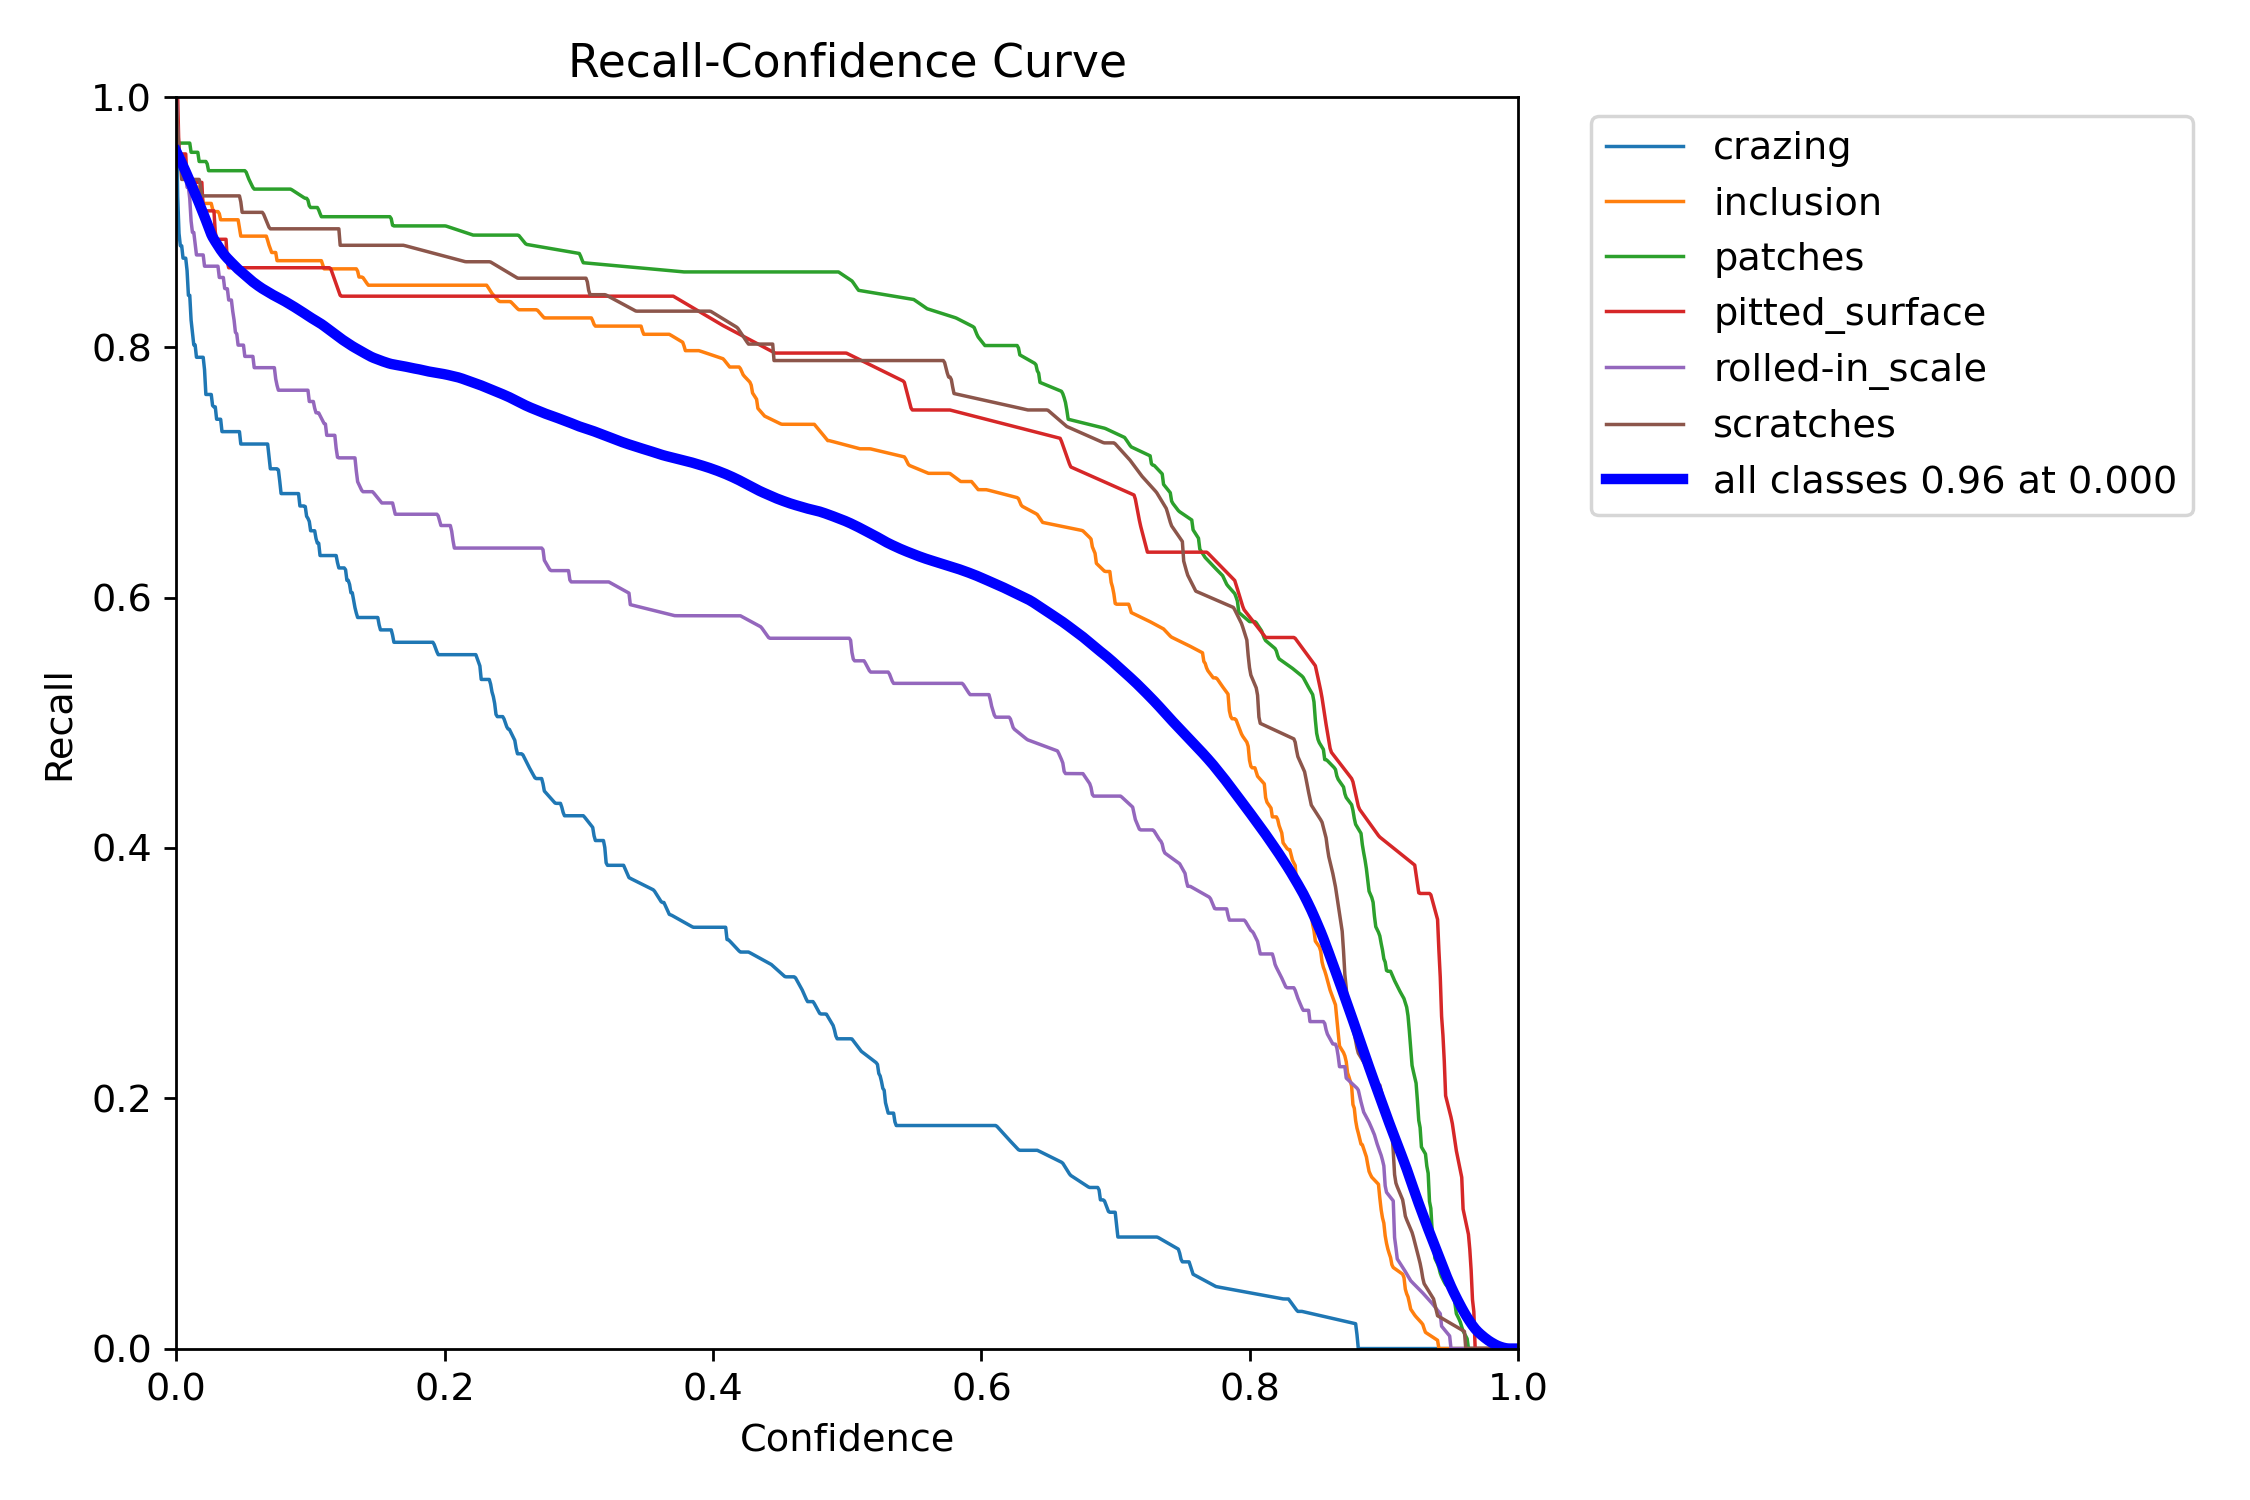

In [12]:
#recall-confidence curve
Image(filename=f'{HOME}/runs/detect/val/R_curve.png', width=600)

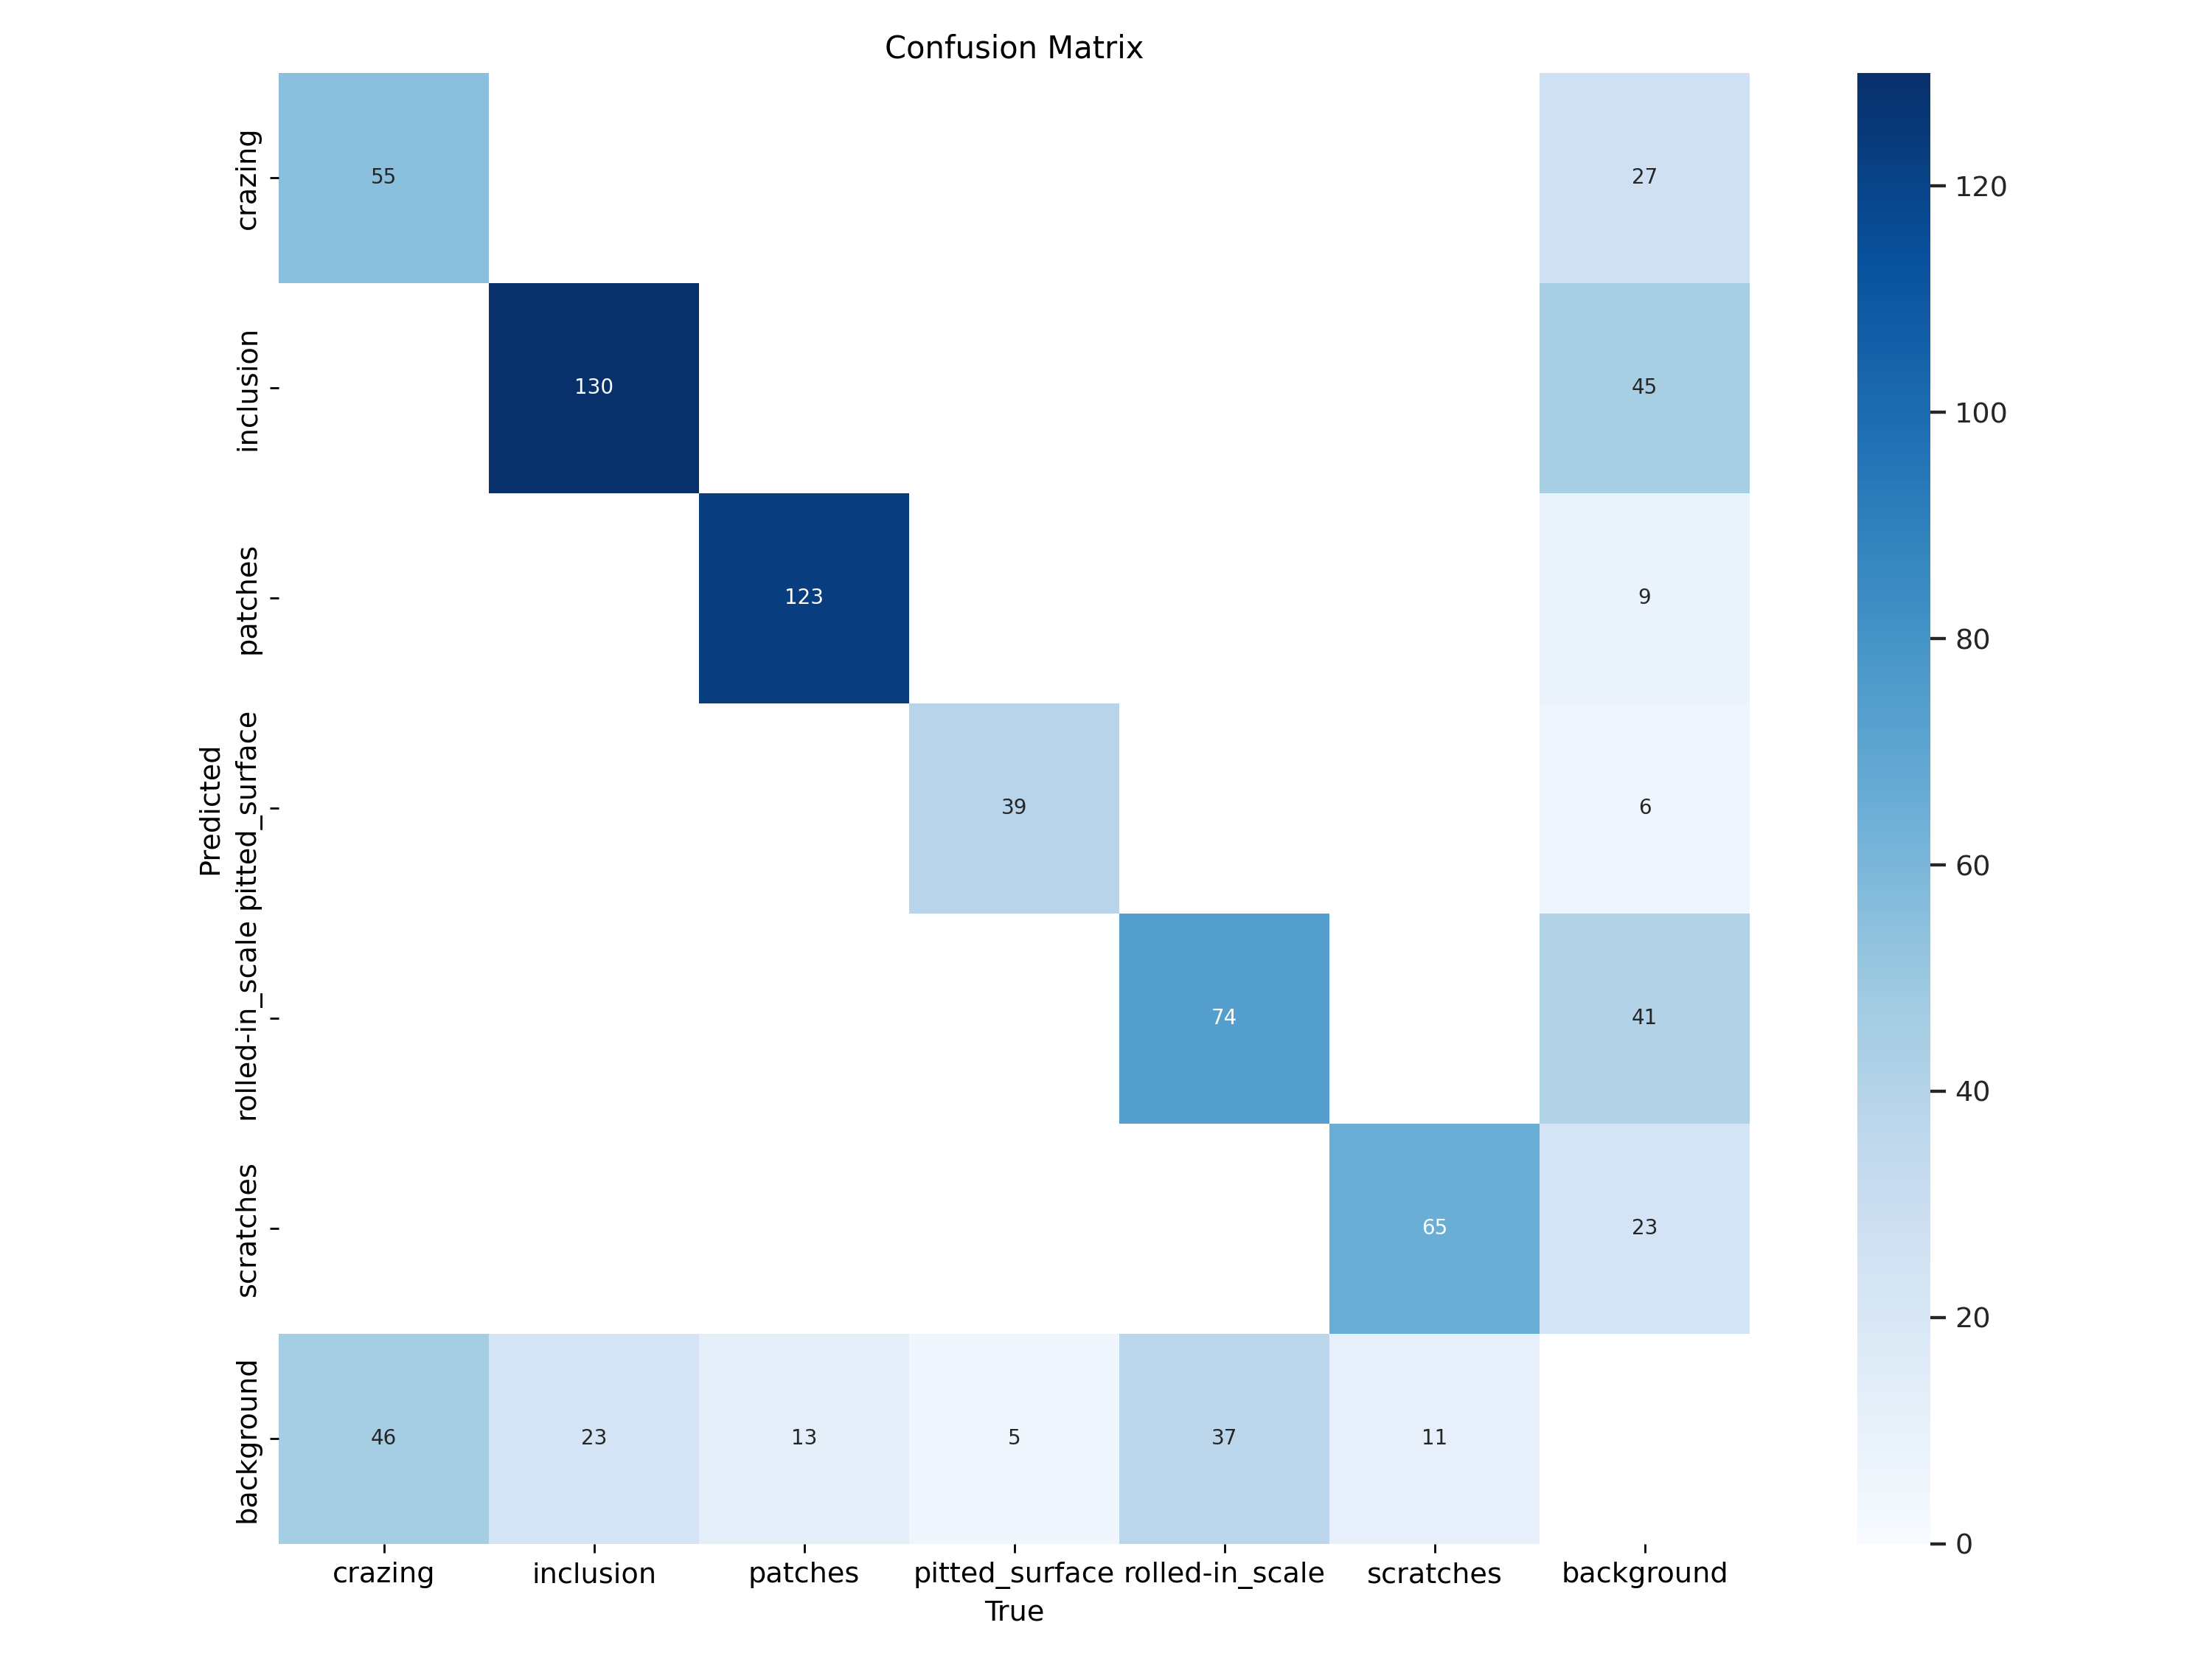

In [13]:
#Confusion matrix
Image(filename=f'{HOME}/runs/detect/val/confusion_matrix.png', width=600)

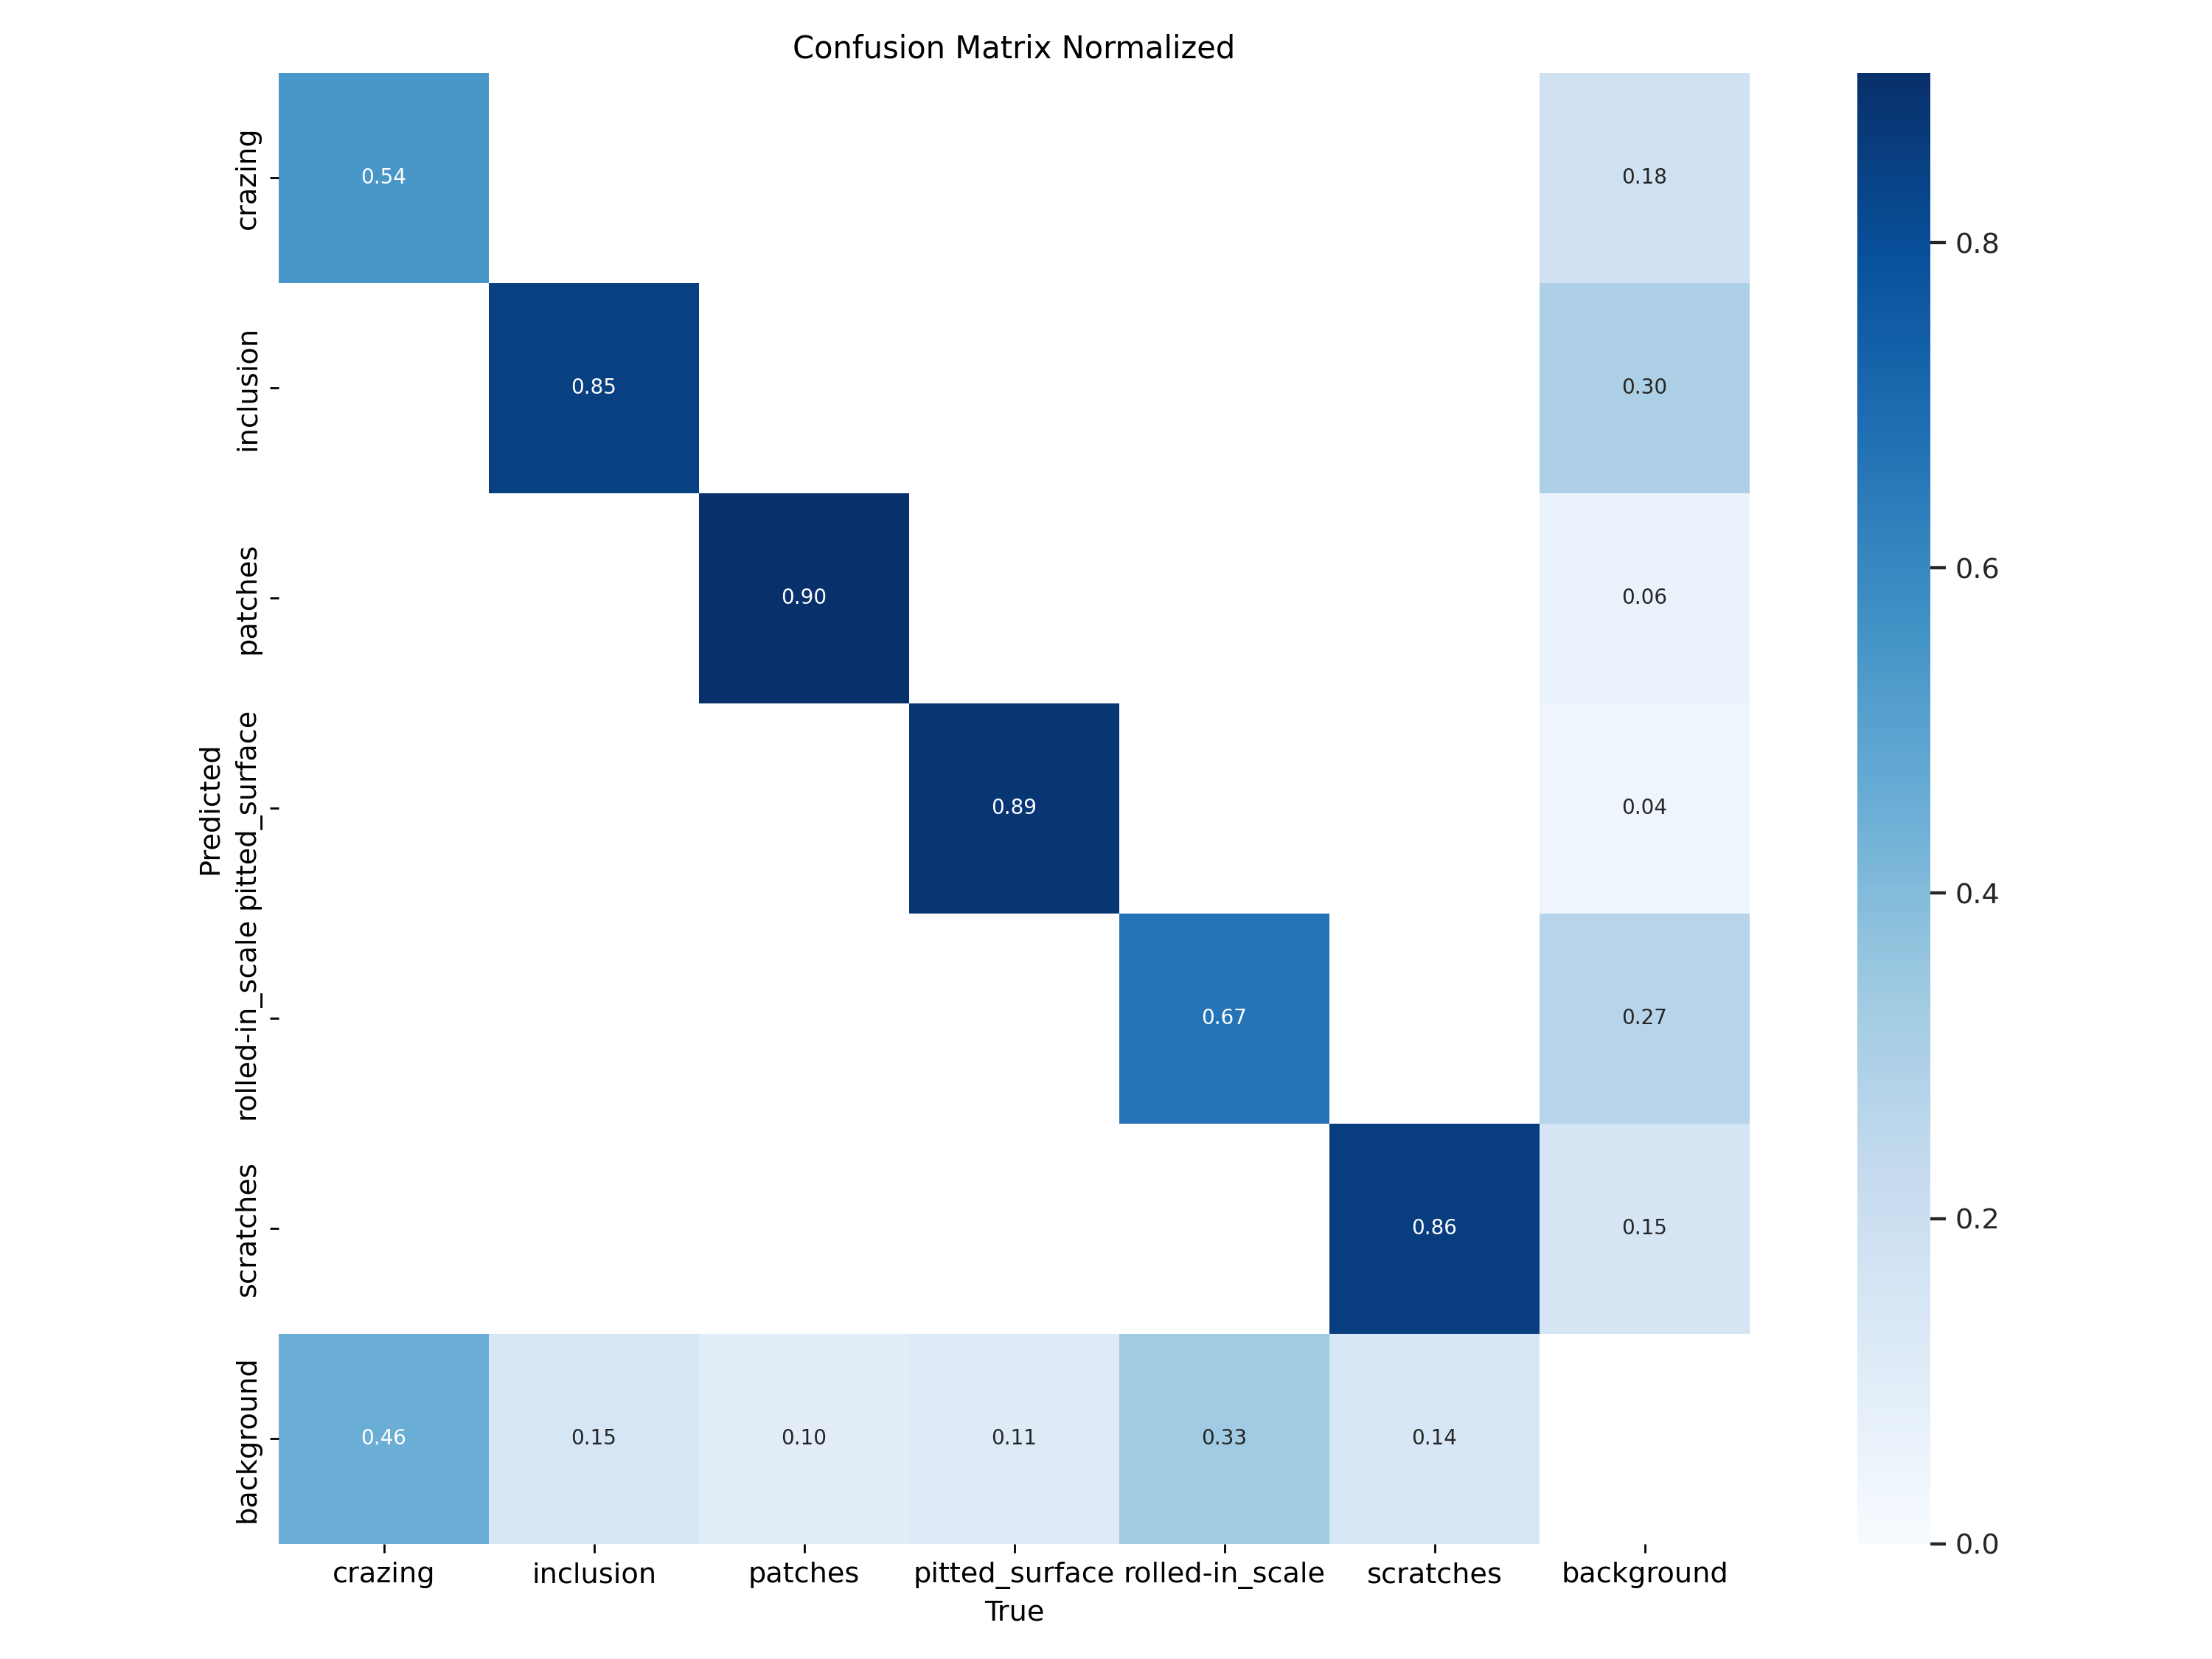

In [14]:
#Normalised confusion matrix
Image(filename=f'{HOME}/runs/detect/val/confusion_matrix_normalized.png', width=600)

Compare actual label with model prediction

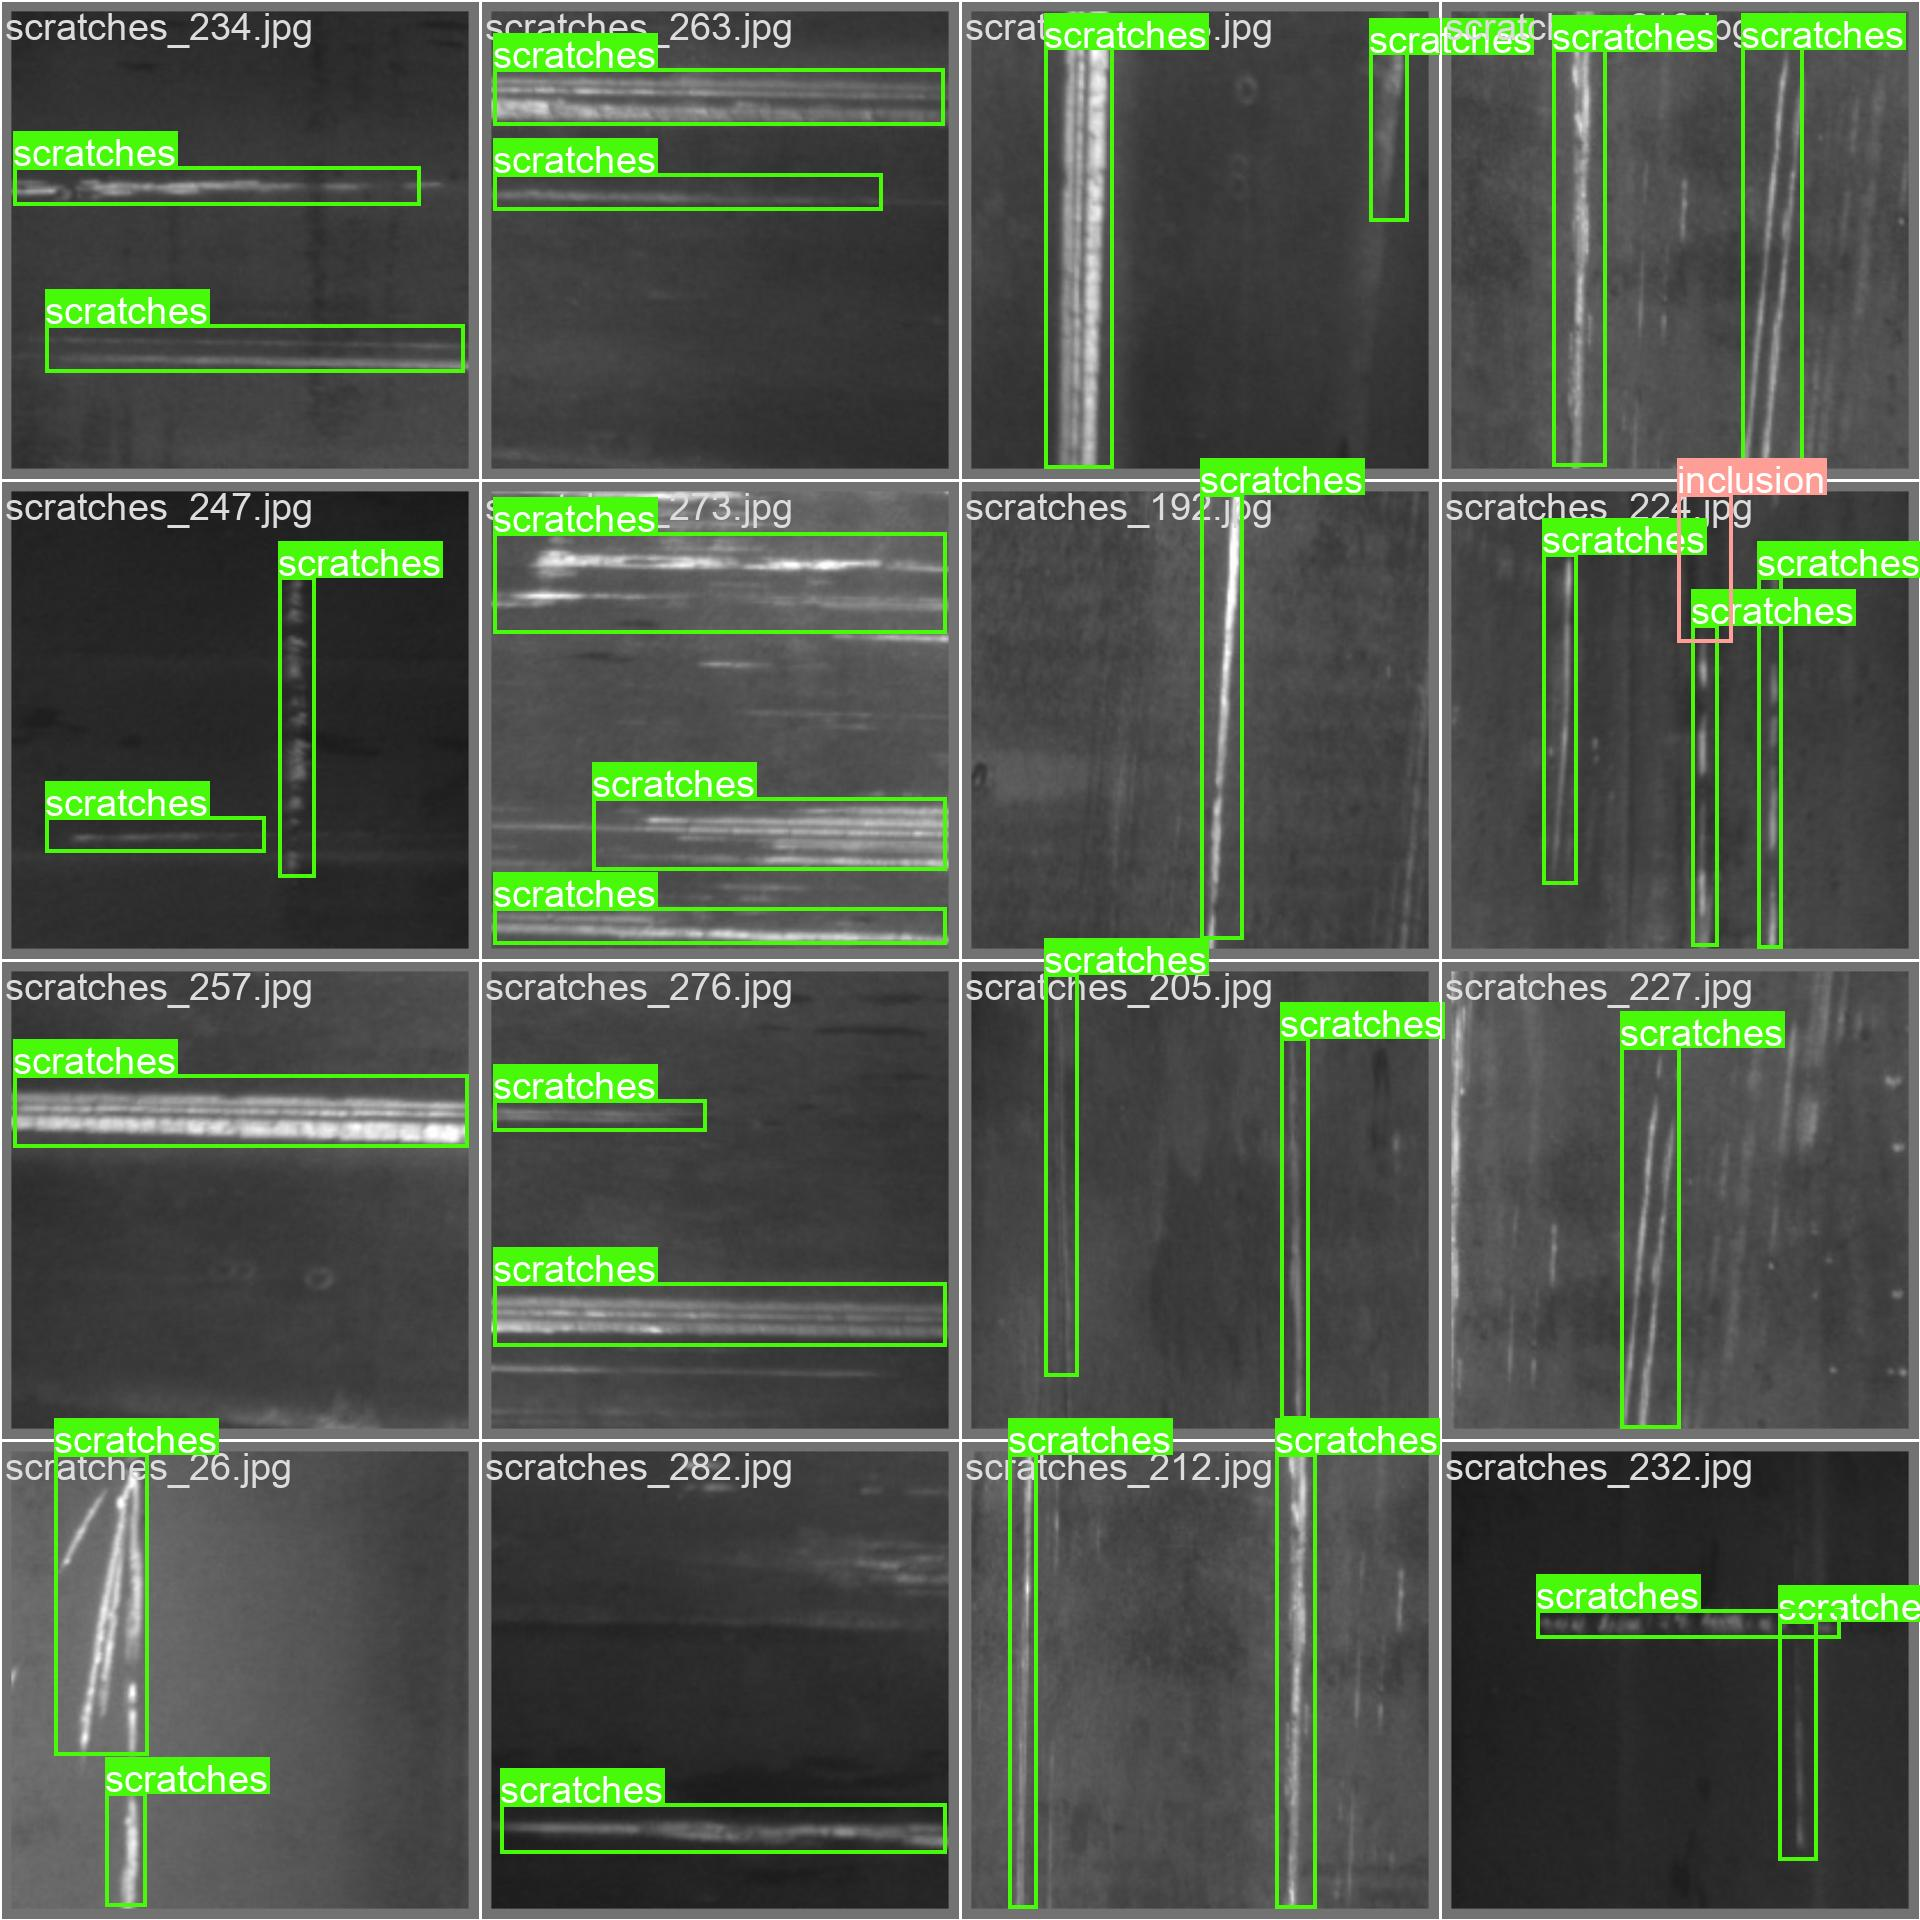

In [15]:
#Defect labels for testing batch 0
Image(filename=f'{HOME}/runs/detect/val/val_batch0_labels.jpg', width=600)

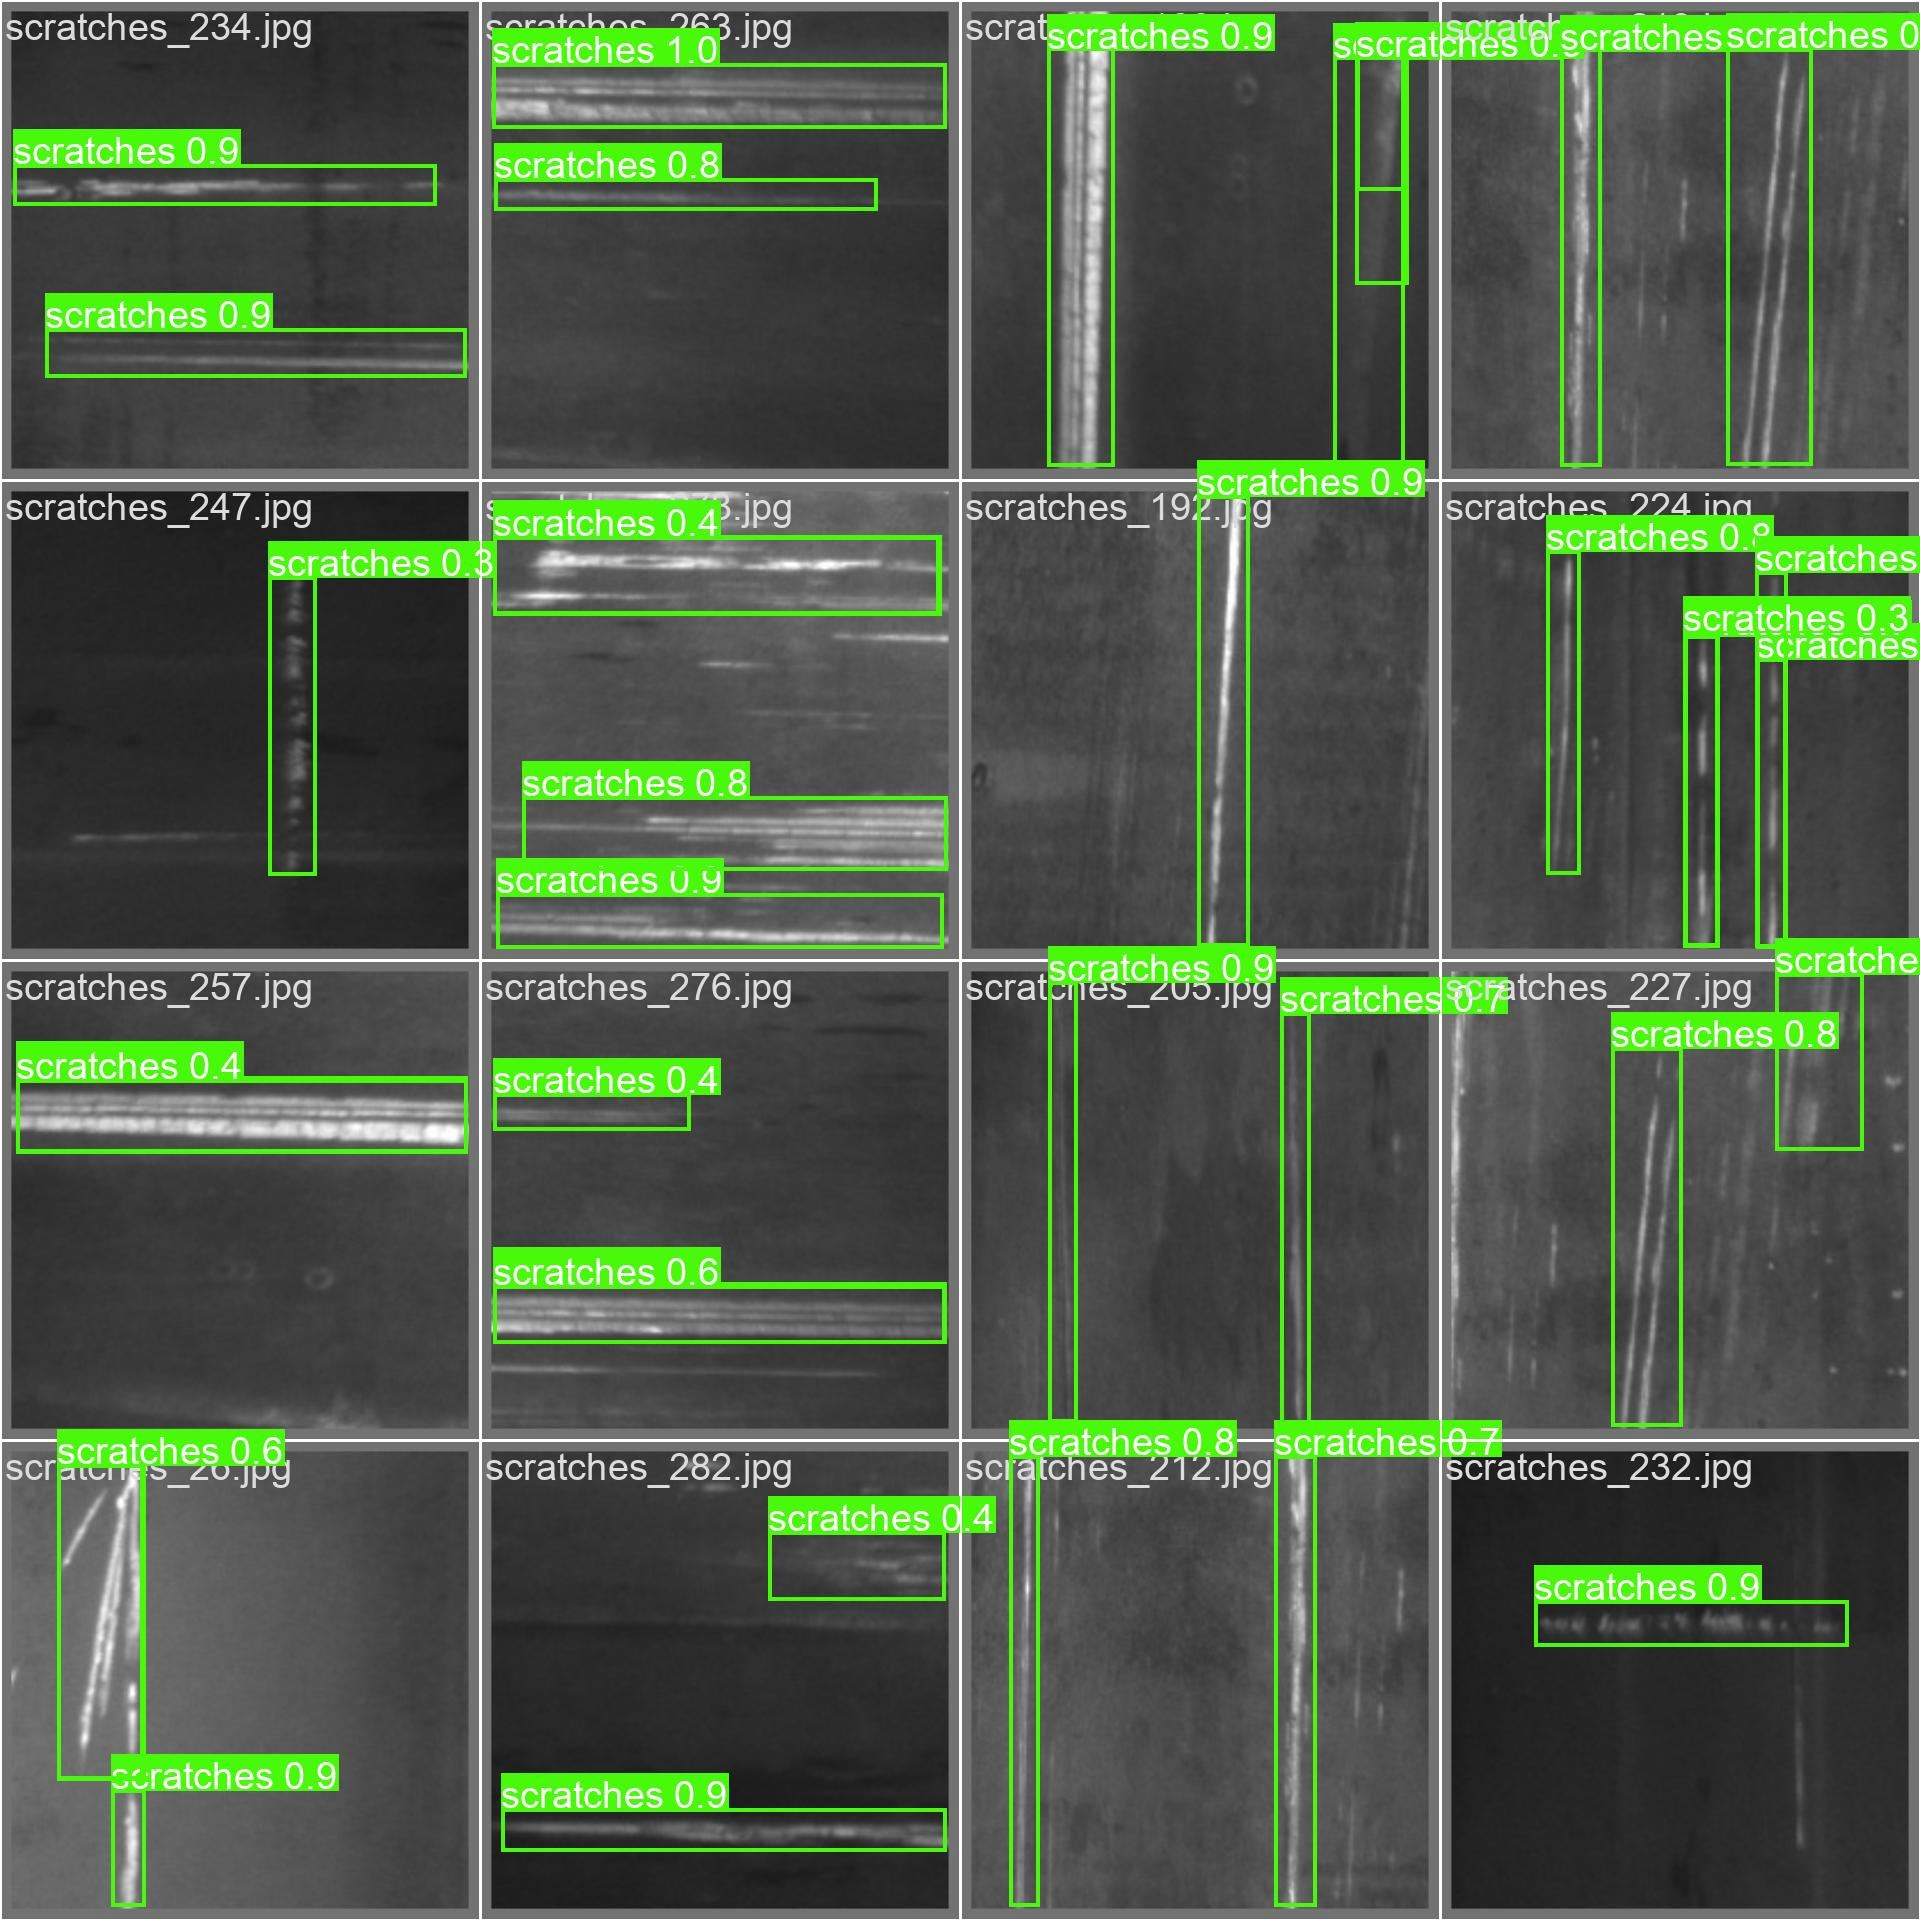

In [16]:
#Model prediction on testing batch 0
Image(filename=f'{HOME}/runs/detect/val/val_batch0_pred.jpg', width=600)

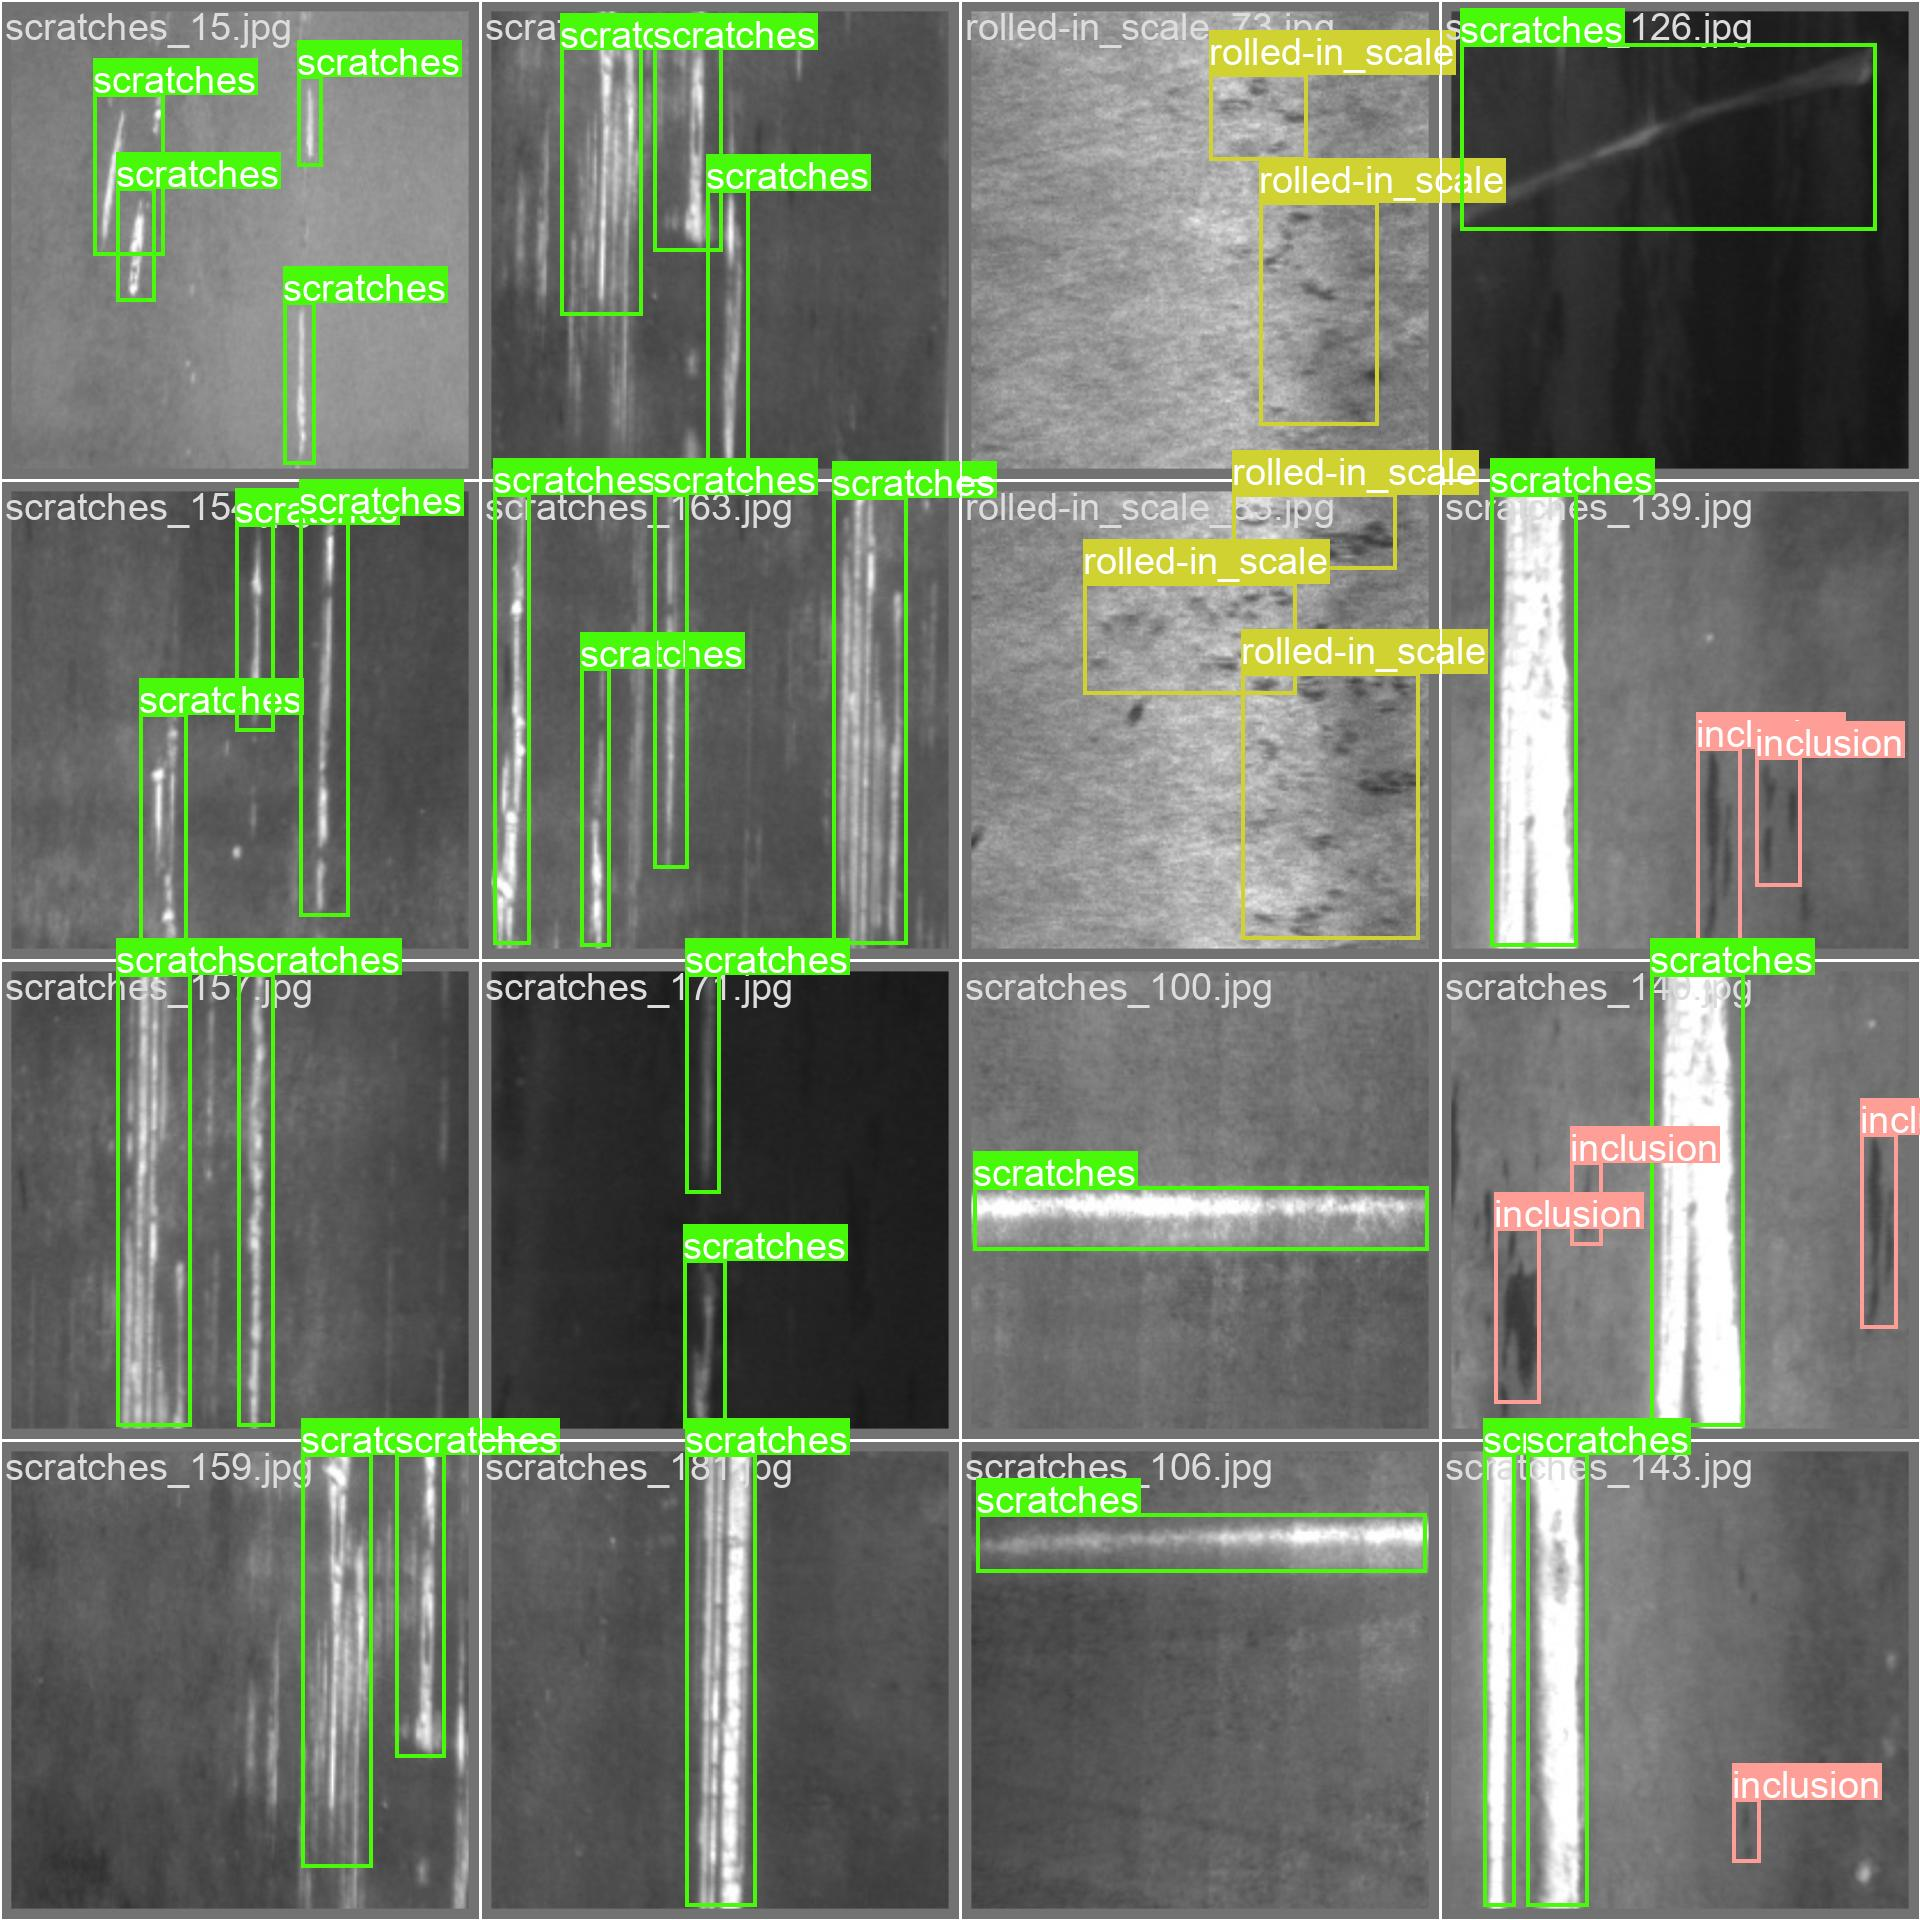

In [17]:
#Defect labels on testing batch 1
Image(filename=f'{HOME}/runs/detect/val/val_batch1_labels.jpg', width=600)

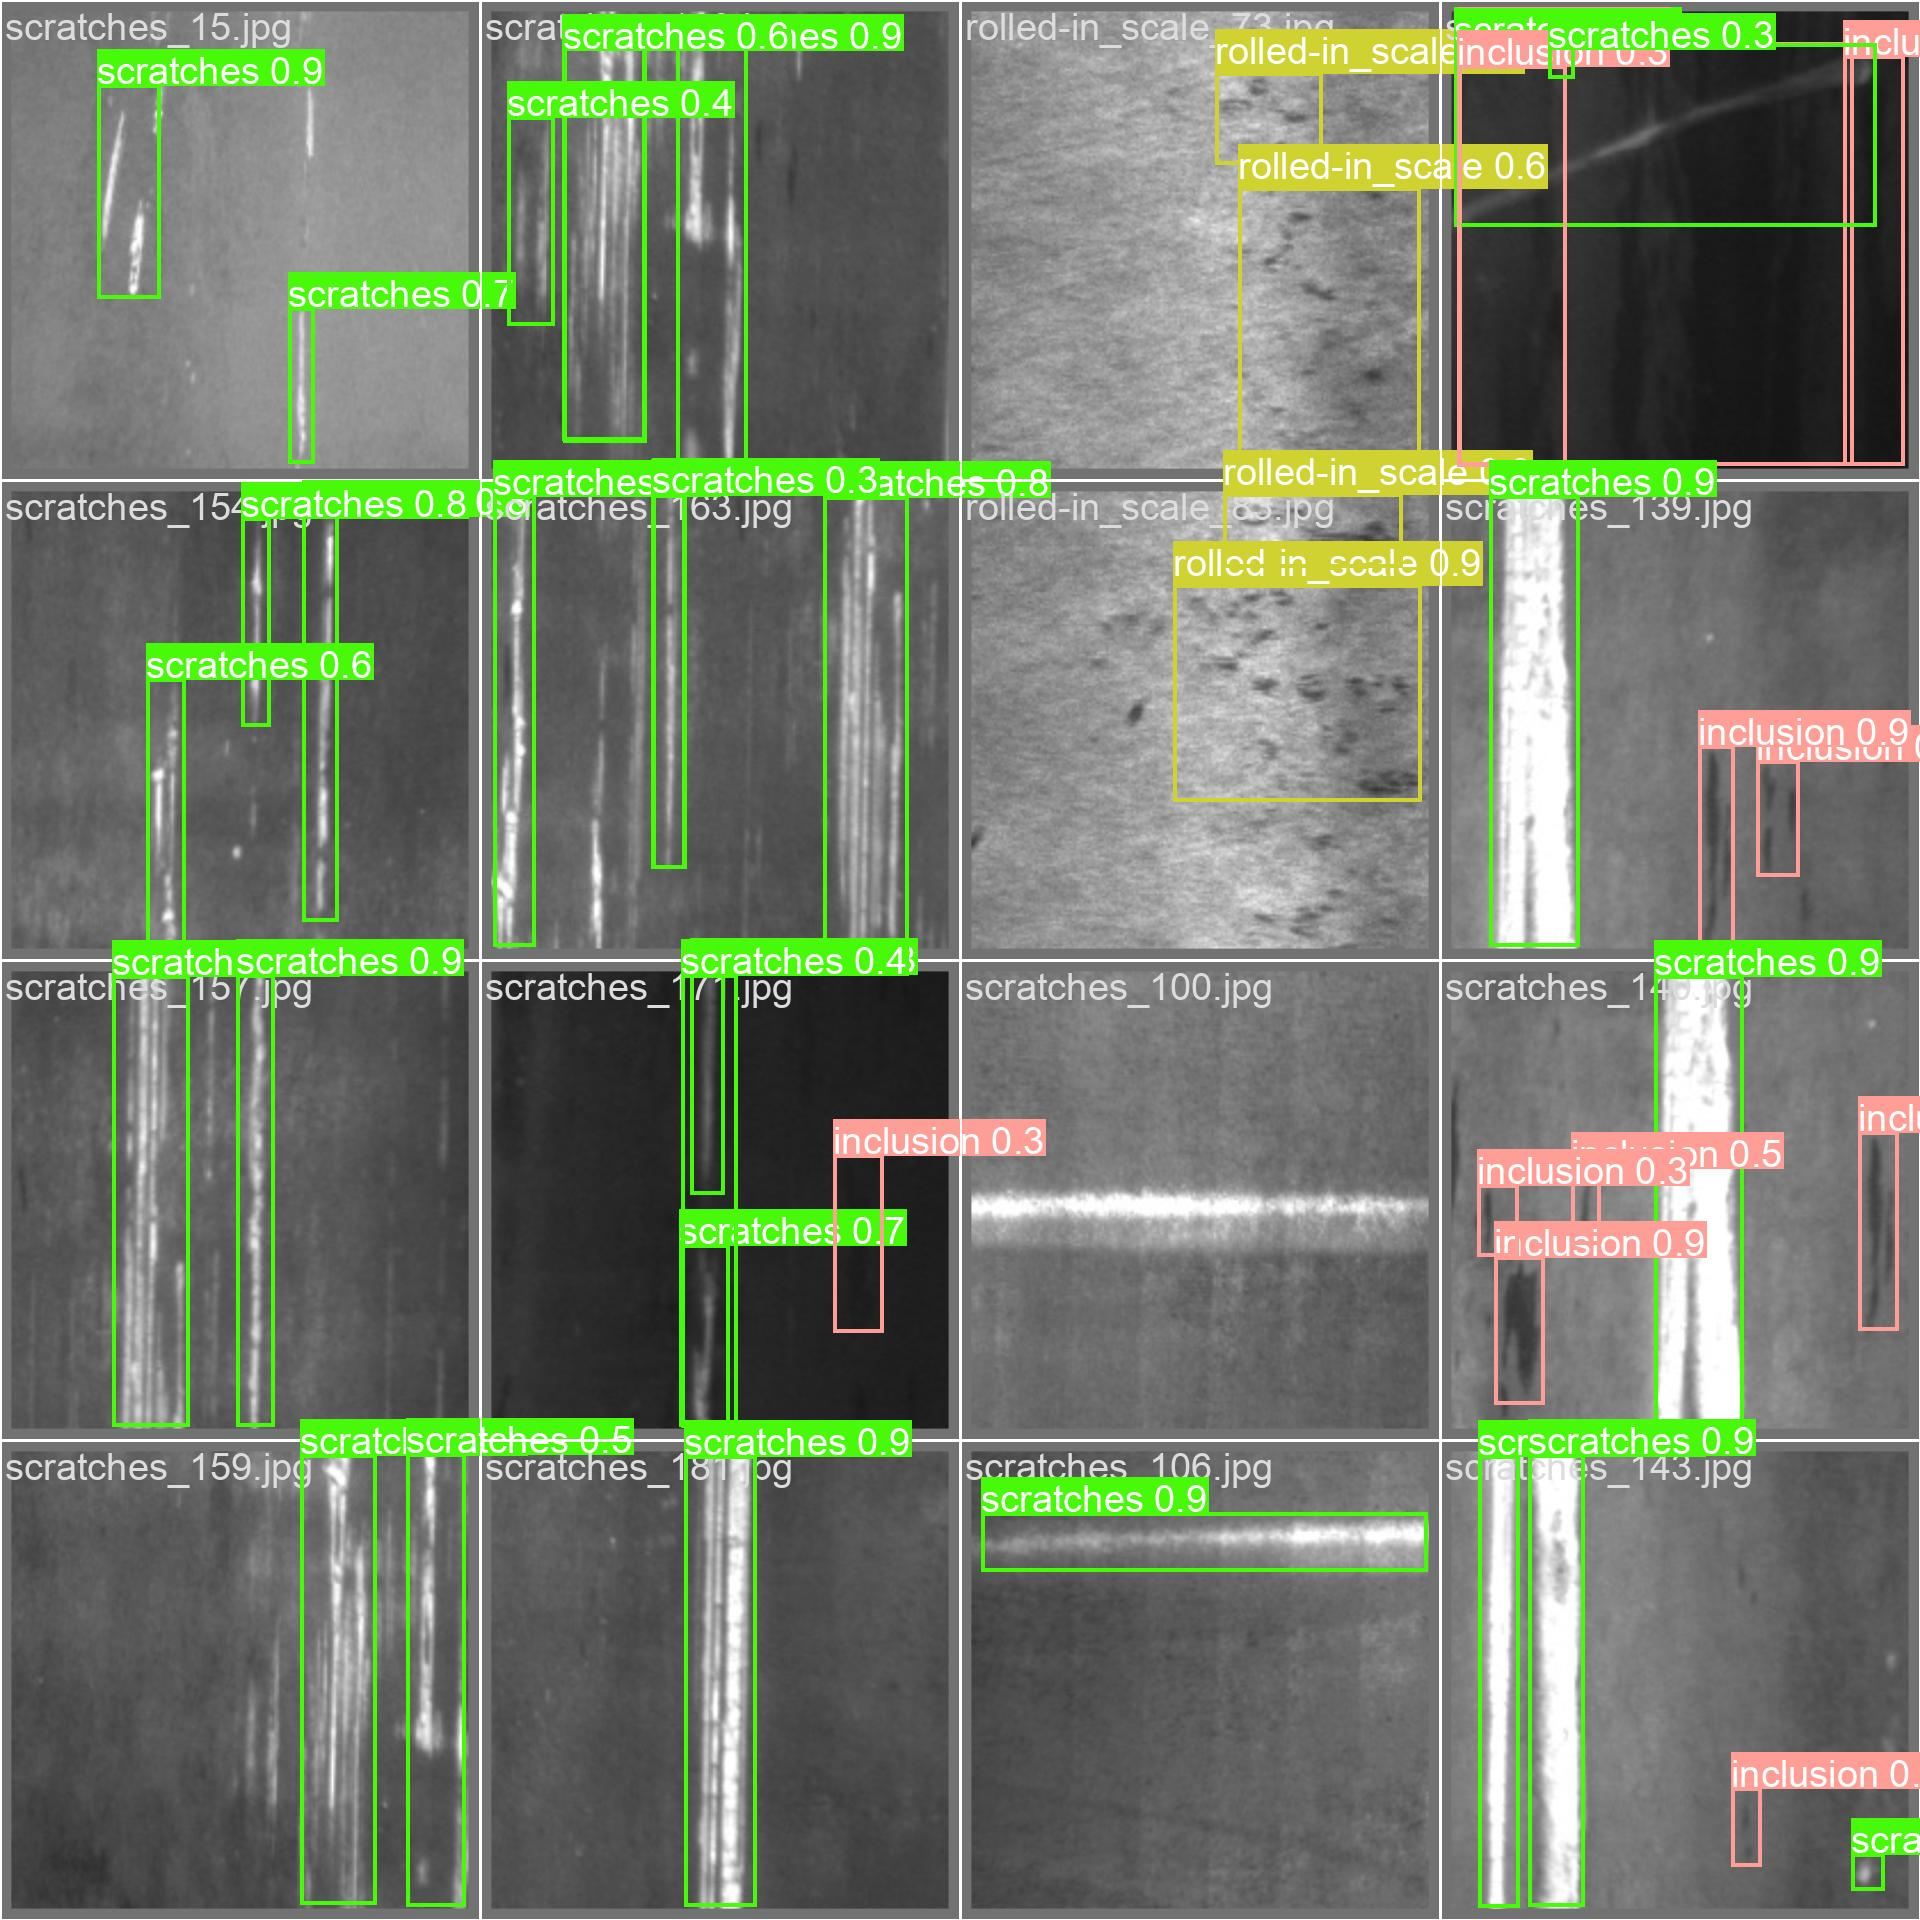

In [18]:
#Model prediction on testing batch 1
Image(filename=f'{HOME}/runs/detect/val/val_batch1_pred.jpg', width=600)

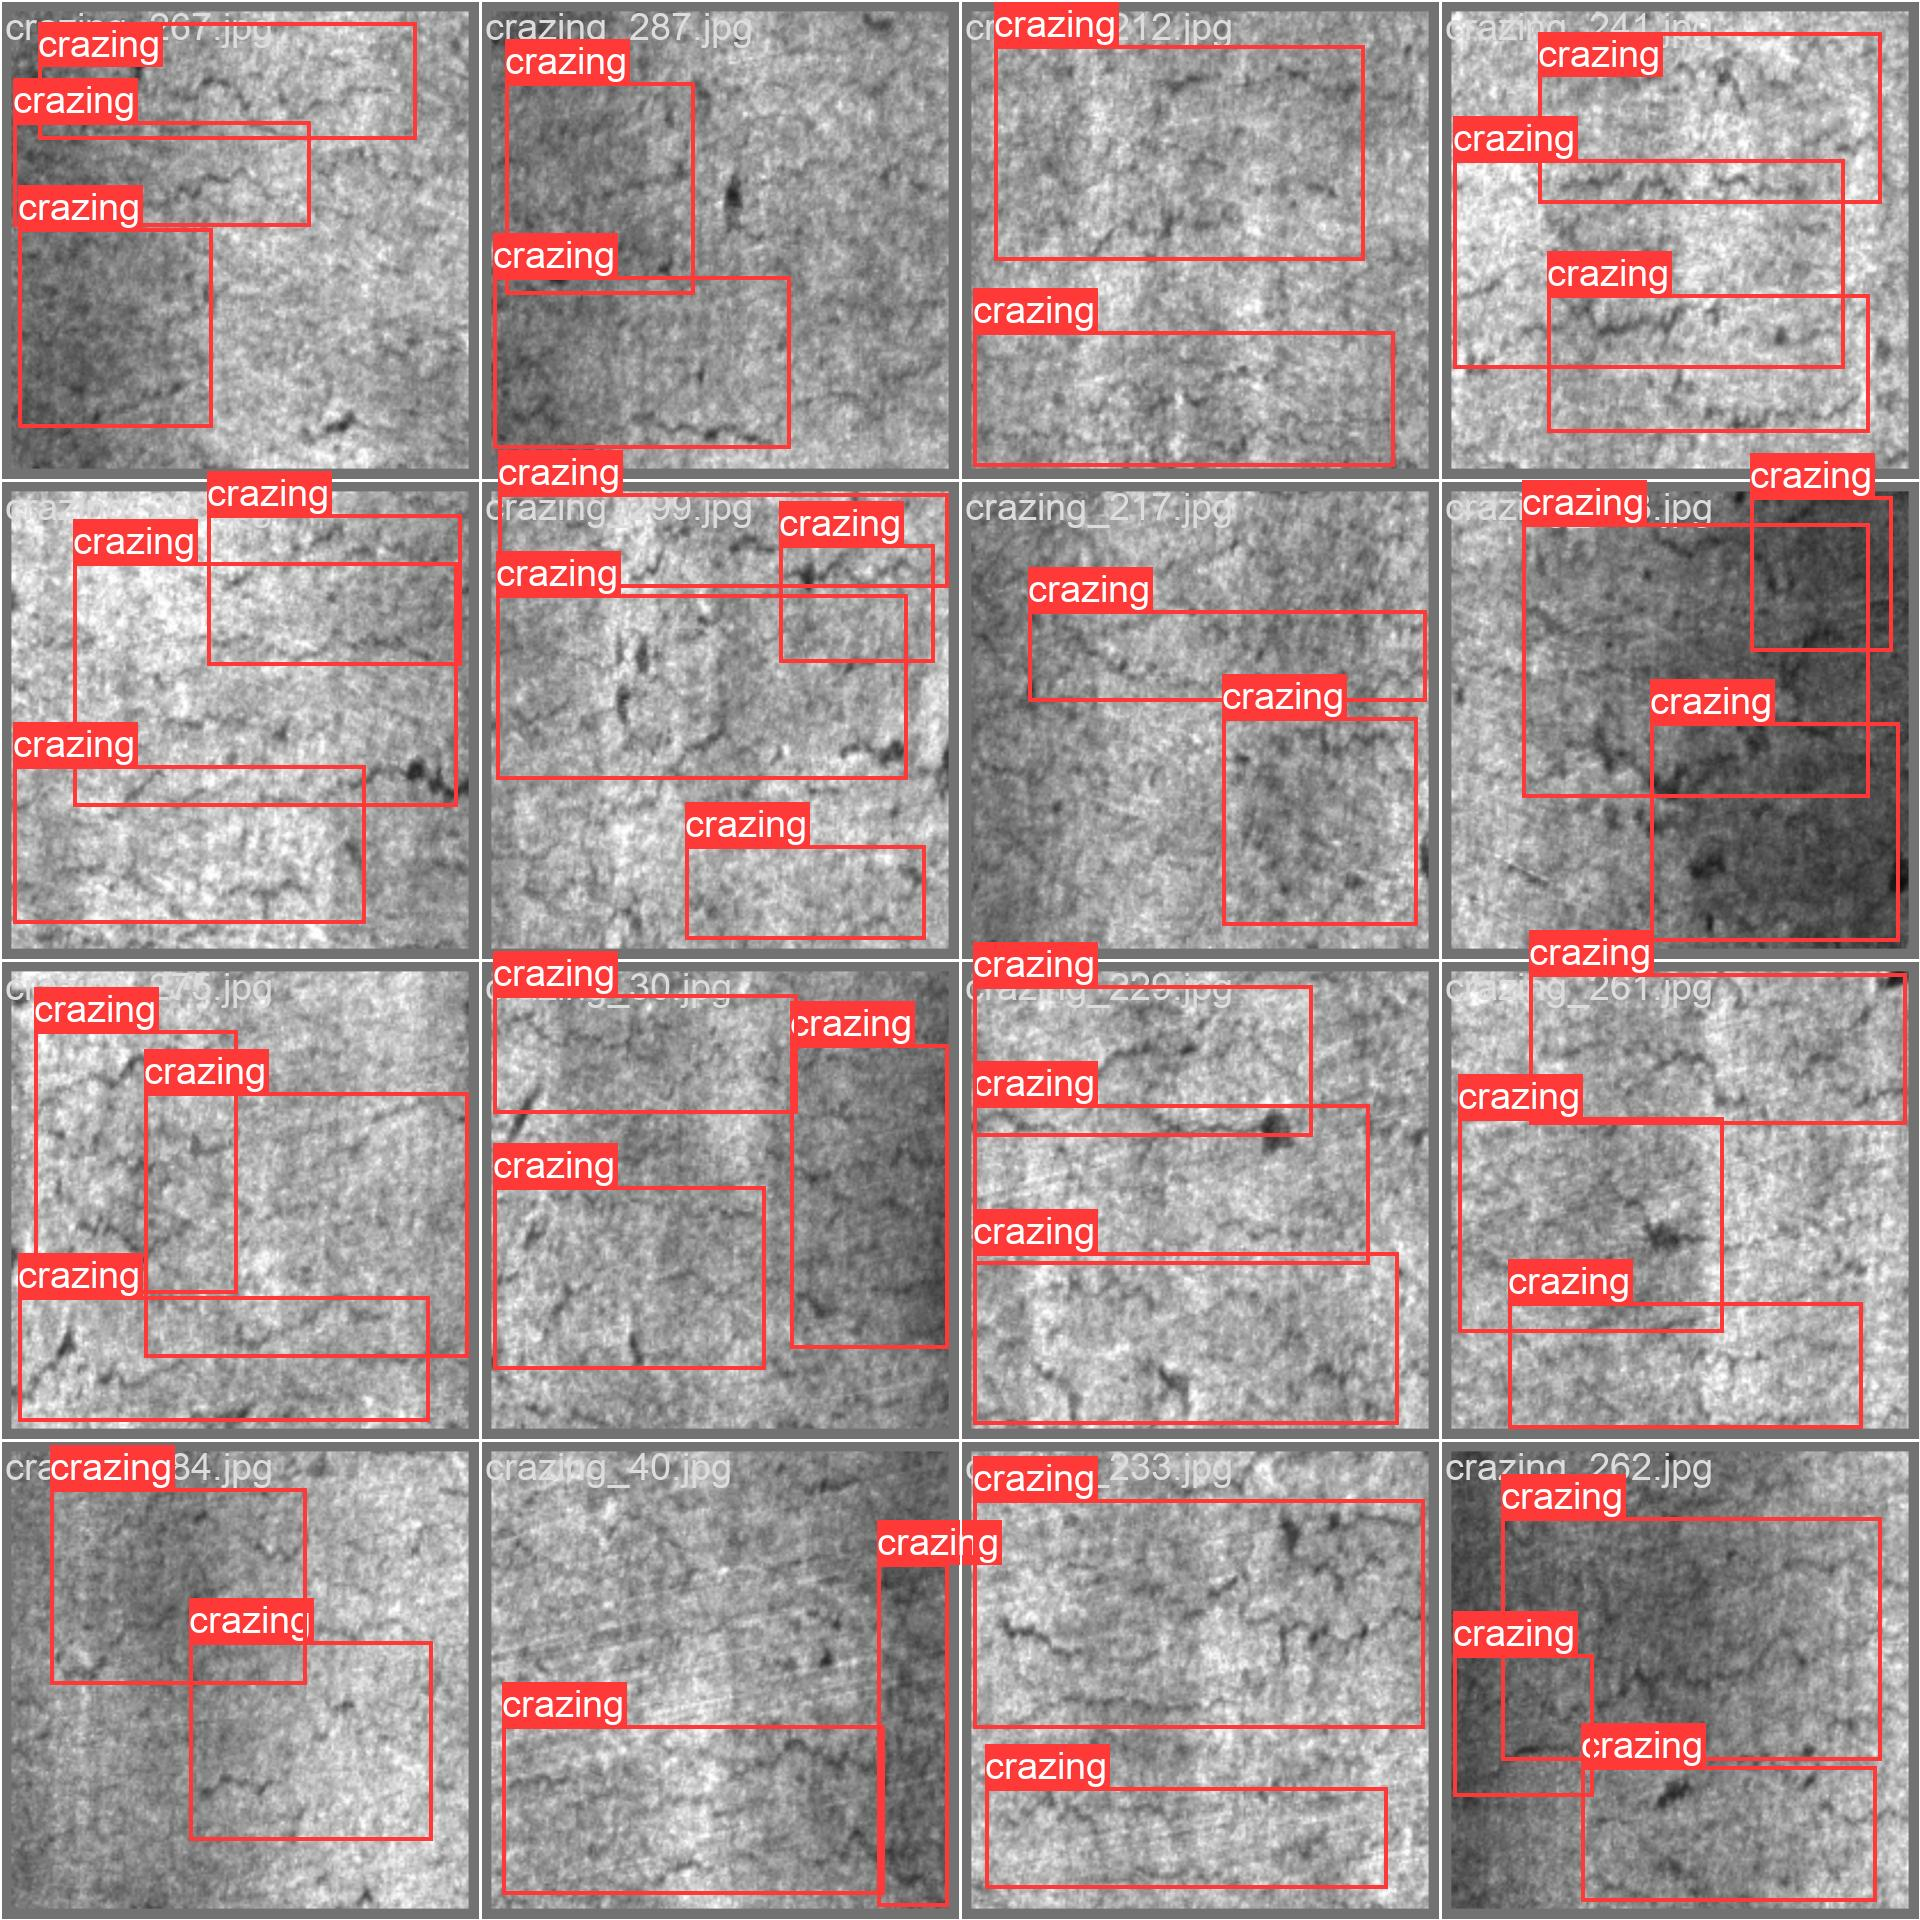

In [19]:
#Defect labels on testing batch 2
Image(filename=f'{HOME}/runs/detect/val/val_batch2_labels.jpg', width=600)


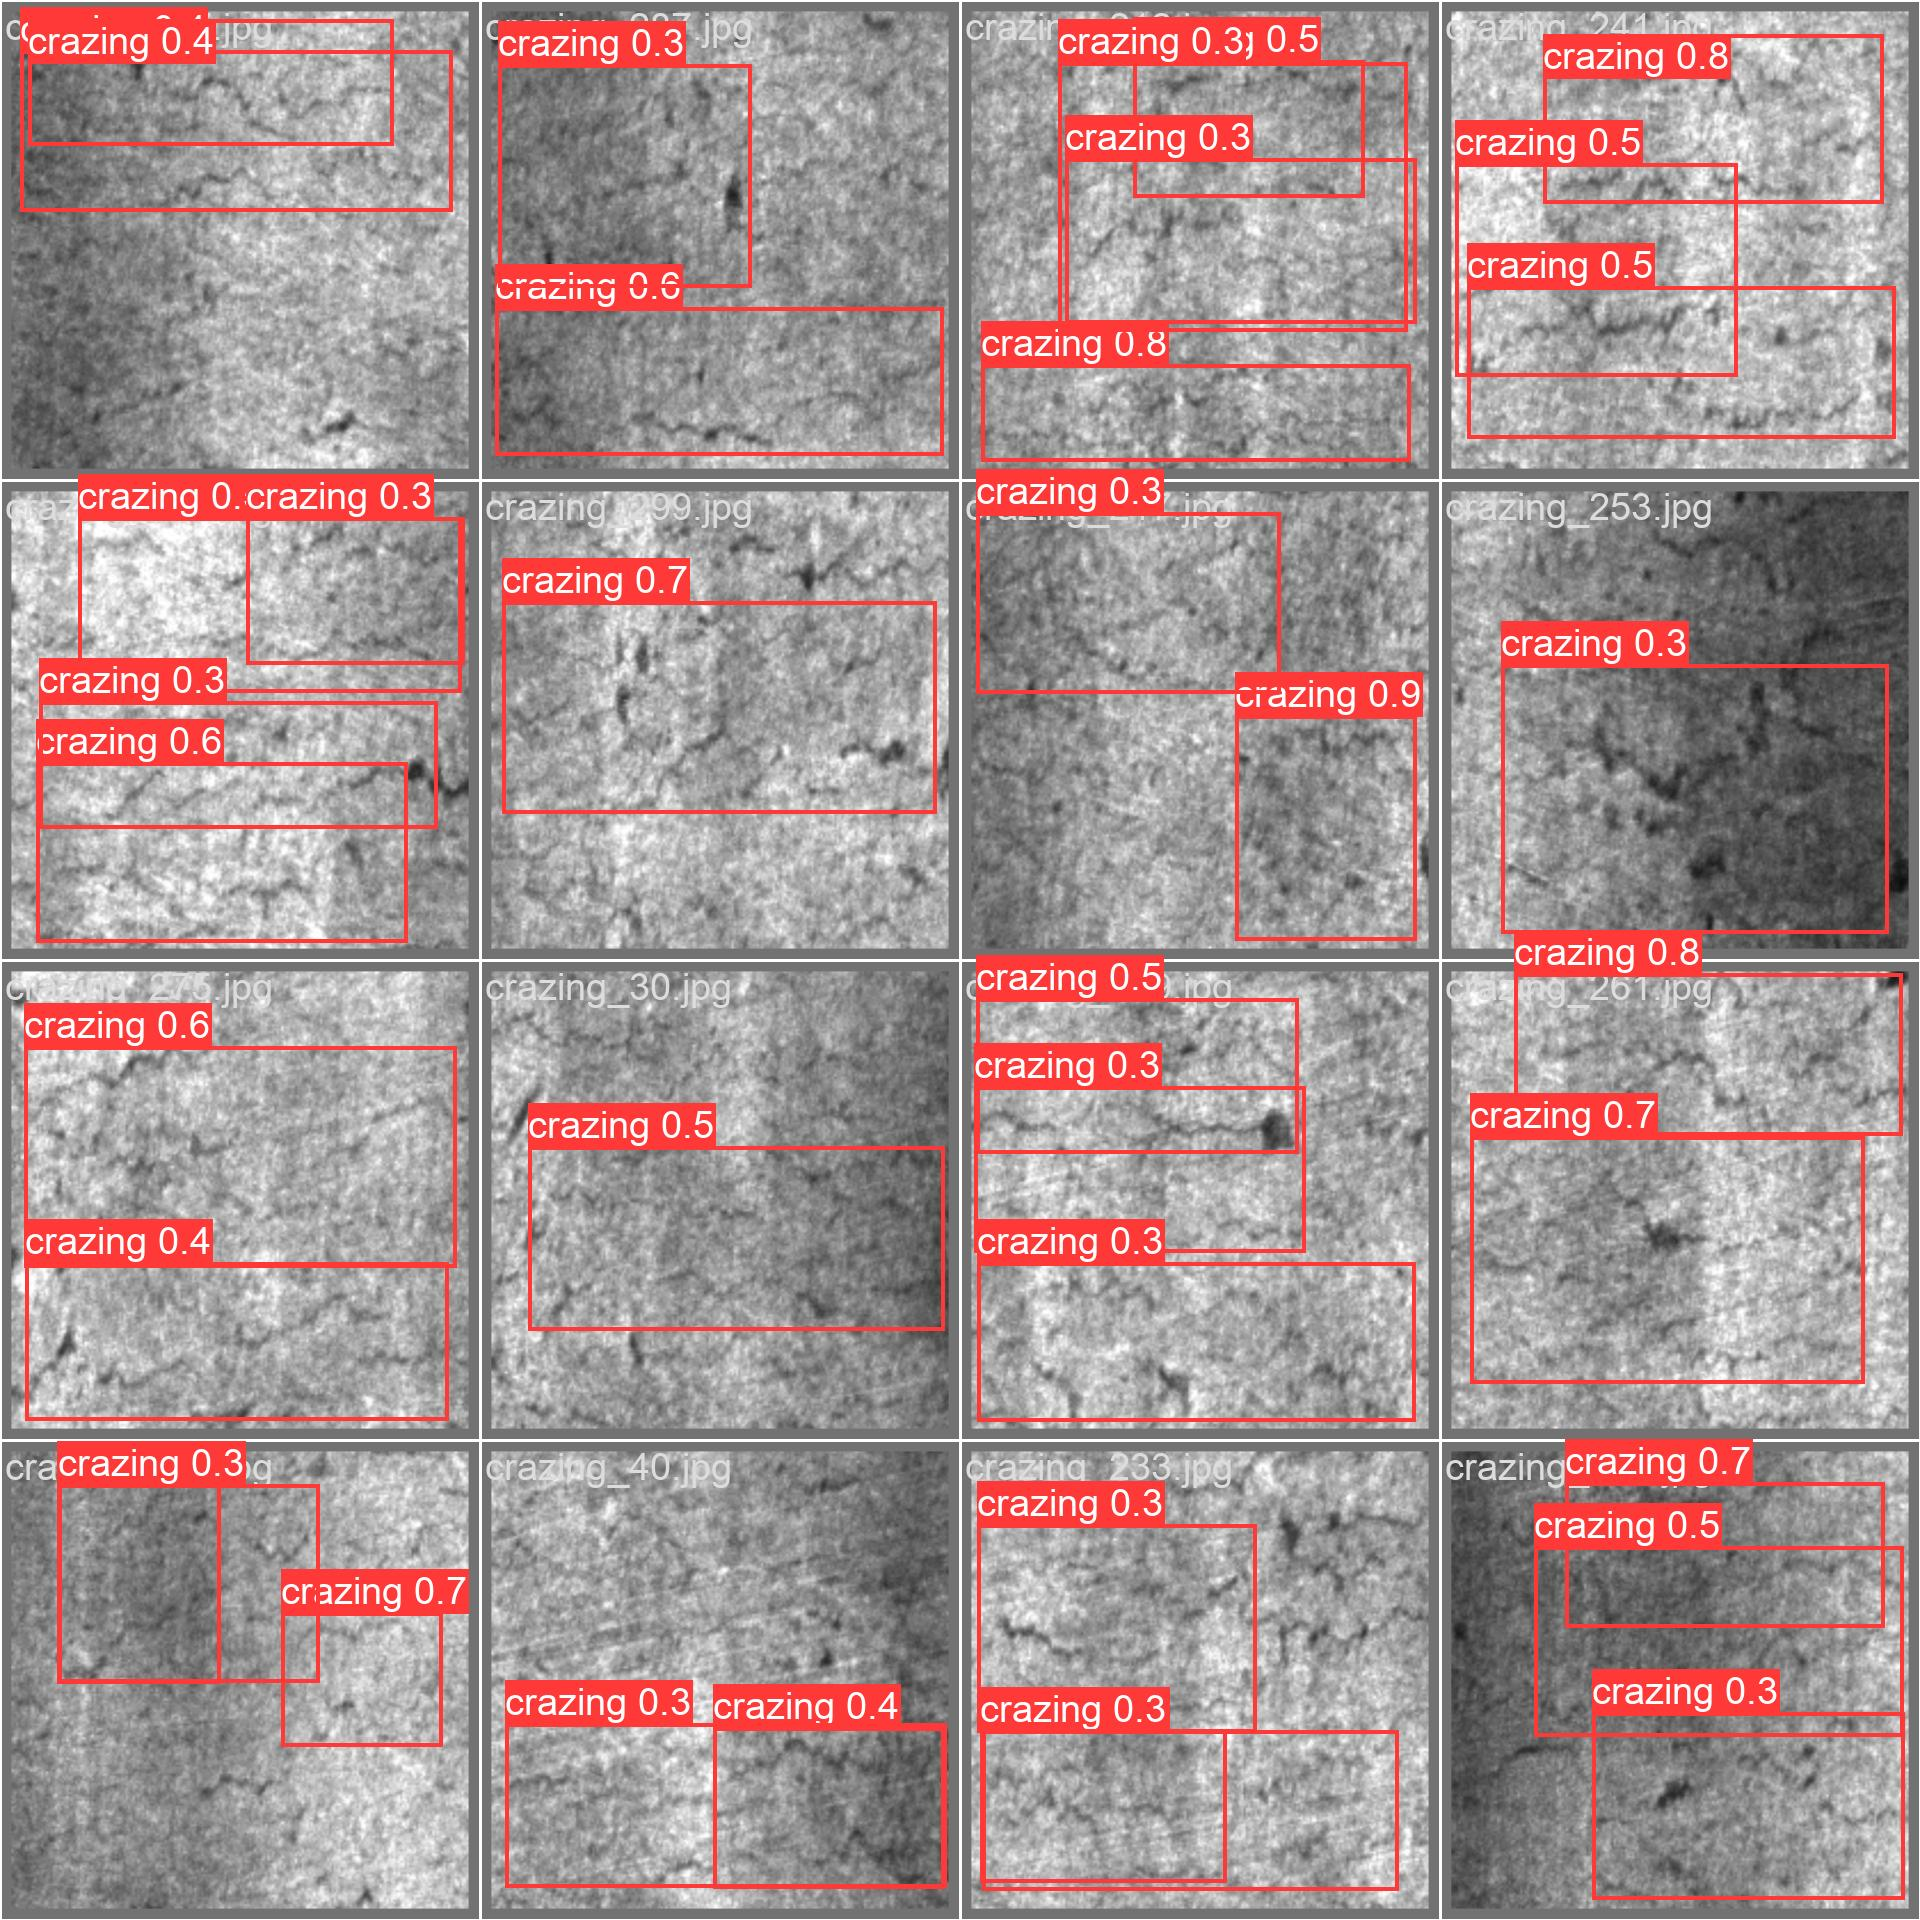

In [20]:
#Model prediction on testing batch 2
Image(filename=f'{HOME}/runs/detect/val/val_batch2_pred.jpg', width=600)

Save the experiment data

In [21]:
#Export the model
model.export(format='onnx')

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (61.1 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 309.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 7.5s, saved as '/content/runs/detect/train/weights/best.onnx' (112.4 MB)

Export complete (10.0s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 data=/co

'/content/runs/detect/train/weights/best.onnx'

In [22]:
#Save all the model file into my google drive
!cp -r /content/runs /content/drive/MyDrive/yolov10_NEUDET_result/